<a href="https://colab.research.google.com/github/prateeknigam9/Kaggle/blob/main/EDA_JaneStreetMarketPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA


## Performance metric
---
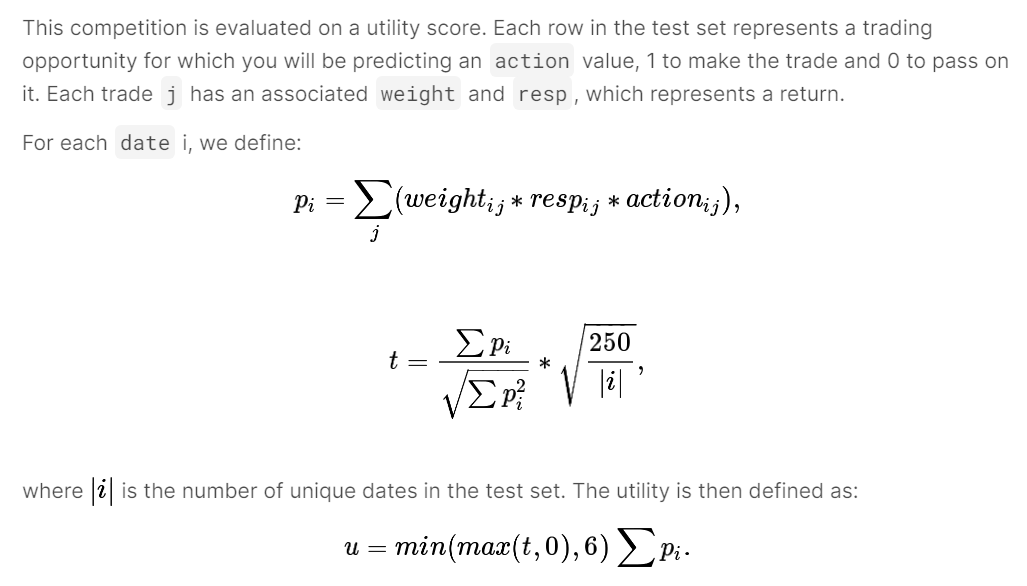

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'

In [ ]:
!kaggle competitions download -c jane-street-market-prediction

  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 65.3MB/s]
  0% 0.00/59.0 [00:00<?, ?B/s]
100% 59.0/59.0 [00:00<00:00, 49.4kB/s]
  0% 0.00/108k [00:00<?, ?B/s]
100% 108k/108k [00:00<00:00, 34.3MB/s]
 73% 12.0M/16.4M [00:00<00:00, 38.5MB/s]
100% 16.4M/16.4M [00:00<00:00, 54.6MB/s]
  0% 0.00/23.3k [00:00<?, ?B/s]
100% 23.3k/23.3k [00:00<00:00, 21.0MB/s]
100% 2.61G/2.61G [00:37<00:00, 83.9MB/s]
100% 2.61G/2.61G [00:37<00:00, 75.2MB/s]


In [ ]:
!7z e train.csv.zip && rm train.csv.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 2801423942 bytes (2672 MiB)

Extracting archive: train.csv.zip
--
Path = train.csv.zip
Type = zip
Physical Size = 2801423942

  0%      0% - train.csv                  1% - train.csv                  2% - train.csv                  3% - train.csv                  4% - train.csv                  5% - train.csv                  6% - train.csv                  7% - train.csv                  8% - train.csv                  9% - 

In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Importing Libraries

In [ ]:
!pip install datatable

     |████████████████████████████████| 83.9MB 37kB/s 


In [ ]:
import datatable as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import missingno as msno
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense,BatchNormalization,Dropout
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
import keras
import operator
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from xgboost import XGBClassifier

In [ ]:
# !wc -l '../input/jane-street-market-prediction/train.csv'
!ls

autoencoder_compress.png		     example_test.csv.zip  kaggle.json
competition.cpython-37m-x86_64-linux-gnu.so  features.csv	   sample_data
example_sample_submission.csv		     __init__.py	   train.csv


In [ ]:
# train_load = dt.fread('../input/jane-street-market-prediction/train.csv')
train_data = dt.fread('train.csv')

In [ ]:
train_data = train_data.to_pandas()

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float64(135), int32(3)
memory usage: 2.4 GB


In [ ]:
feature_columns=[]
non_feature_columns=[]
for col in list(train_data.columns):
    if 'feature' in col:
        feature_columns.append(col)
    else:
        non_feature_columns.append(col)

# Train CSV Exploration
Each trade consist of total 138 features, date,resp features, weight and features 0-129 and a ts-id featues. 
We will investigate each feature one by one

In [ ]:
train_data[non_feature_columns].head()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,ts_id
0,0,0.000000,0.009916,0.014079,0.008773,0.001390,0.006270,0
1,0,16.673515,-0.002828,-0.003226,-0.007319,-0.011114,-0.009792,1
2,0,0.000000,0.025134,0.027607,0.033406,0.034380,0.023970,2
3,0,0.000000,-0.004730,-0.003273,-0.000461,-0.000476,-0.003200,3
4,0,0.138531,0.001252,0.002165,-0.001215,-0.006219,-0.002604,4


## Weight

In [ ]:
train_data['weight'][:10]

0     0.000000
1    16.673515
2     0.000000
3     0.000000
4     0.138531
5     0.000000
6     0.190575
7     3.820844
8     0.116557
9     0.160117
Name: weight, dtype: float64

Text(0.5, 1.0, 'Weight Distribution with weight 0')

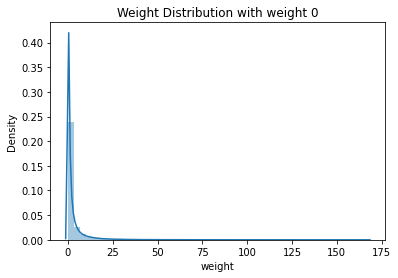

In [ ]:
sns.distplot(train_data['weight'])
plt.title('Weight Distribution with weight 0')

We observed from the distribution of weight feature is, that it is highly skewed towards 0, as in the dataset we have trades with weight = 0 which were intentionally included in the dataset for completeness, although such trades will not contribute towards the scoring evaluation.

In [ ]:
print(f"Percentage of zero weights is: {((sum(train_data['weight'] == 0))/len(train_data))*100}%")

Percentage of zero weights is: 17.117989567833554%


We observe that percentage of zero weights is 17%, and since these weights would not contribute to towards scoring evaluation, we can drop them

In [ ]:
# train_data.drop(train_data[train_data['weight'] == 0].index,inplace=True)
# train_data.reset_index(drop=True,inplace=True)

In [ ]:
min_w = min(train_data['weight'])
max_w = max(train_data['weight'])
print("Minimum value of weight is :",min_w)
print("Maximum value of weight is :",max_w)

Minimum value of weight is : 0.0
Maximum value of weight is : 167.2937151011765


We Observe that although after removing 0 weighted rows, min value of weight feature is 0.006 which is very small and close to zero, so we might not observe a large impact on the weight distribution plot

Text(0.5, 1.0, 'Weight Distribution without weight 0')

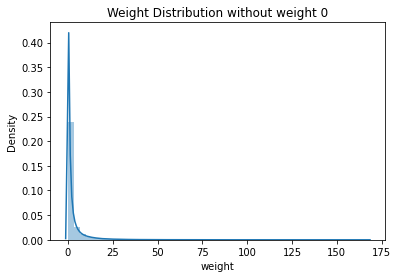

In [ ]:
sns.distplot(train_data['weight'])
plt.title('Weight Distribution without weight 0')

In [ ]:
print(f"The Date with minimum weight is : {train_data[train_data['weight'] == min_w]['date'].values[0]}")
print(f"The Date with maximum weight is : {train_data[train_data['weight'] == max_w]['date'].values[0]}")

The Date with minimum weight is : 0
The Date with maximum weight is : 446


## Resp features

The resp value, as well as several other resp_{1,2,3,4} values represents returns over different time horizons.

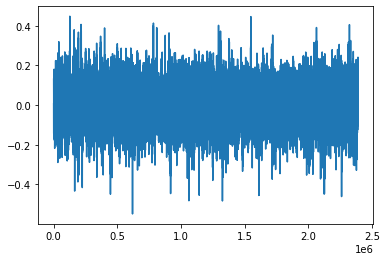

In [ ]:
#plot of resp feature
plt.plot(train_data['resp'])

As the distribution of resp features are defined as returns over different time horizons, distributed on time-series.

[]

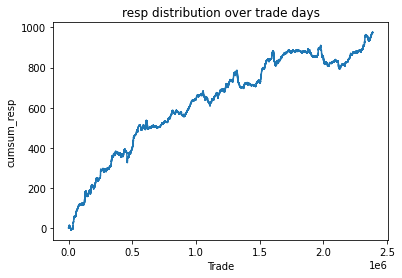

In [ ]:
#Distribution of resp
plt.plot(train_data['resp'].cumsum())
plt.xlabel('Trade')
plt.ylabel('cumsum_resp')
plt.title('resp distribution over trade days')
plt.plot()

No handles with labels found to put in legend.


[]

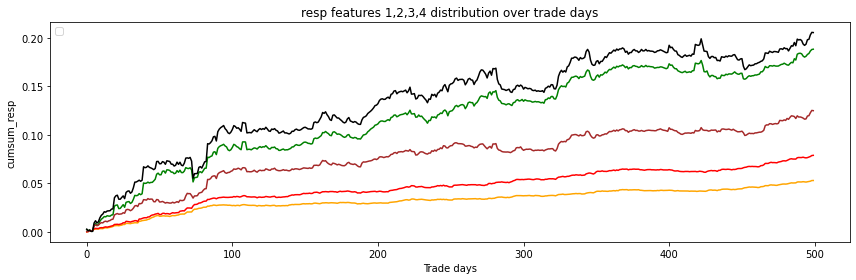

In [ ]:
#Distribution of resp_1,2,3,4
plt.figure(figsize=(12,4))
plt.plot((train_data.groupby('date')['resp'].mean()).cumsum(),'green')
plt.plot((train_data.groupby('date')['resp_1'].mean()).cumsum(),'orange')
plt.plot((train_data.groupby('date')['resp_2'].mean()).cumsum(),'red')
plt.plot((train_data.groupby('date')['resp_3'].mean()).cumsum(),'brown')
plt.plot((train_data.groupby('date')['resp_4'].mean()).cumsum(),'black')
plt.xlabel('Trade days')
plt.ylabel('cumsum_resp')
plt.title('resp features 1,2,3,4 distribution over trade days')
plt.legend(loc='upper left')
plt.tight_layout()
plt.plot()

It is observed from the plot that, resp is closer to resp_4

Referred from :https://www.investopedia.com/terms/t/timehorizon.asp, Time Horizon, is the period of time one expects to hold an investment until they need the money back.The longer the longer the time horizon, the longer the power of compounding has to work and also the more aggressive an investor can be in their portfolio and vice versa.



Each trade has an associated weight and resp, which together represents a return on the trade

No handles with labels found to put in legend.


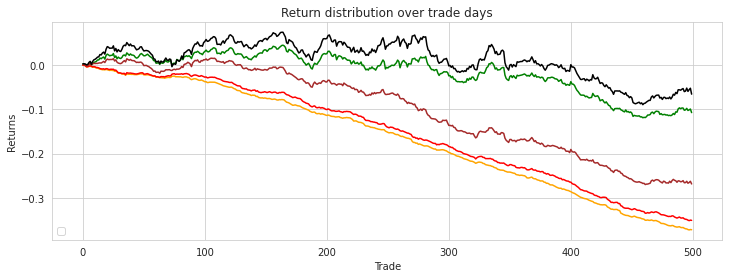

In [ ]:
sns.set_style('whitegrid')
train_data['return_resp']= train_data['weight']*train_data['resp']
train_data['return_resp1']= train_data['weight']*train_data['resp_1']
train_data['return_resp2']= train_data['weight']*train_data['resp_2']
train_data['return_resp3']= train_data['weight']*train_data['resp_3']
train_data['return_resp4']= train_data['weight']*train_data['resp_4']

plt.figure(figsize=(12,4))
plt.plot((train_data.groupby('date')['return_resp'].mean()).cumsum(),'green')
plt.plot((train_data.groupby('date')['return_resp1'].mean()).cumsum(),'orange')
plt.plot((train_data.groupby('date')['return_resp2'].mean()).cumsum(),'red')
plt.plot((train_data.groupby('date')['return_resp3'].mean()).cumsum(),'brown')
plt.plot((train_data.groupby('date')['return_resp4'].mean()).cumsum(),'black')
plt.xlabel('Trade')
plt.ylabel('Returns')
plt.title('Return distribution over trade days')
plt.legend(loc='lower left')

Thus, observed from the above distribution that as referred from the blog, the returns  of resp_4 is higher than resp_1,It can be fetched out that the returns are dependent on the time horizon, therefore this resp and weight features can be utilized to create action

**Preparing Target column**

Each row in the dataset represents a trading opportunity, for which you will be predicting an action value: 1 to make the trade and 0 to pass on it. Each trade has an associated weight and resp, which together represents a return on the trade, so assuming if it is positive our action will be 1, to invest or 0 to not invest.

In [ ]:
train_data['action'] = (train_data['resp']>0).astype('int')
train_data['action'].value_counts()

1    1204974
0    1185517
Name: action, dtype: int64

From the discussion referred [here](https://https://www.kaggle.com/c/jane-street-market-prediction/discussion/199515). we can extract that if resp > 0 can be an enough feature to predict the target.

Now that we have target feature, we can do target based analysis of weight and resp feature.

In [ ]:
train_data.head()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,...,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id,return_resp,return_resp1,return_resp2,return_resp3,return_resp4,action
0,0,0.000000,0.009916,0.014079,0.008773,0.001390,0.006270,1,-1.872746,-2.191242,-0.474163,-0.323046,0.014688,-0.002484,NaN,NaN,-0.989982,-1.055090,NaN,NaN,-2.667671,-2.001475,-1.703595,-2.196892,NaN,NaN,1.483295,1.307466,NaN,NaN,1.175200,0.967805,1.608410,1.319365,NaN,NaN,-0.515073,-0.448988,NaN,NaN,...,0.434466,NaN,-0.292035,0.317003,-2.605820,NaN,2.896986,NaN,1.485813,4.147254,-2.238831,NaN,-0.892724,NaN,-0.156332,0.622816,-3.921523,NaN,2.561593,NaN,3.457757,6.649580,-1.472686,NaN,NaN,1.168391,8.313583,1.782433,14.018213,2.653056,12.600292,2.301488,11.445807,0,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,0,16.673515,-0.002828,-0.003226,-0.007319,-0.011114,-0.009792,-1,-1.349537,-1.704709,0.068058,0.028432,0.193794,0.138212,NaN,NaN,-0.151877,-0.384952,NaN,NaN,1.225838,0.789076,1.110580,1.102281,NaN,NaN,-0.590600,-0.625682,NaN,NaN,-0.543425,-0.547486,-0.706600,-0.667806,NaN,NaN,0.910558,0.914465,NaN,NaN,...,0.024913,NaN,-0.413607,-0.073672,-2.434546,NaN,0.949879,NaN,0.724655,1.622137,-2.209020,NaN,-1.332492,NaN,-0.586619,-1.040491,-3.946097,NaN,0.983440,NaN,1.357907,1.612348,-1.664544,NaN,NaN,-1.178850,1.777472,-0.915458,2.831612,-1.417010,2.297459,-1.304614,1.898684,1,-0.163262,-0.047156,-0.053794,-0.122042,-0.185310,0
2,0,0.000000,0.025134,0.027607,0.033406,0.034380,0.023970,-1,0.812780,-0.256156,0.806463,0.400221,-0.614188,-0.354800,NaN,NaN,5.448261,2.668029,NaN,NaN,3.836342,2.183258,3.902698,3.045431,NaN,NaN,-1.141082,-0.979962,NaN,NaN,-1.157585,-0.966803,-1.430973,-1.103432,NaN,NaN,5.131559,4.314714,NaN,NaN,...,1.585939,NaN,0.193996,0.953114,-2.674838,NaN,2.200085,NaN,0.537175,2.156228,-3.568648,NaN,1.193823,NaN,0.097345,0.796214,-4.090058,NaN,2.548596,NaN,0.882588,1.817895,-2.432424,NaN,NaN,6.115747,9.667908,5.542871,11.671595,7.281757,10.060014,6.638248,9.427299,2,0.000000,0.000000,0.000000,0.000000,0.000000,1
3,0,0.000000,-0.004730,-0.003273,-0.000461,-0.000476,-0.003200,-1,1.174378,0.344640,0.066872,0.009357,-1.006373,-0.676458,NaN,NaN,4.508206,2.484260,NaN,NaN,2.902176,1.799163,3.192700,2.848359,NaN,NaN,-1.401637,-1.428248,NaN,NaN,-1.421175,-1.487976,-1.756415,-1.647543,NaN,NaN,4.766182,4.528353,NaN,NaN,...,-1.338859,NaN,-1.257774,-1.194013,-1.719062,NaN,-0.940190,NaN,-1.510224,-1.781693,-3.373969,NaN,2.513074,NaN,0.424964,1.992887,-2.616856,NaN,0.561528,NaN,-0.994041,0.099560,-2.485993,NaN,NaN,2.838853,0.499251,3.033732,1.513488,4.397532,1.266037,3.856384,1.013469,3,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0
4,0,0.138531,0.001252,0.002165,-0.001215,-0.006219,-0.002604,1,-3.172026,-3.093182,-0.161518,-0.128149,-0.195006,-0.143780,NaN,NaN,2.683018,1.450991,NaN,NaN,1.257761,0.632336,0.905204,0.575275,NaN,NaN,2.550883,2.484082,NaN,NaN,2.502828,2.606440,2.731251,2.566561,NaN,NaN,-1.477905,-1.722451,NaN,NaN,...,-0.172561,NaN,-0.299516,-0.420021,-2.354611,NaN,0.762192,NaN,1.598620,0.623132,-1.742540,NaN,-0.934675,NaN,-0.373013,-1.213540,-3.677787,NaN,2.684119,NaN,2.861848,2.134804,-1.279284,NaN,NaN,0.344850,4.101145,0.614252,6.623456,0.800129,5.233243,0.362636,3.926633,4,-0.000361,0.000173,0.000300,-0.000168,-0.000861,0


It is obvious that since we have used weight and resp features directly to create target feature,, the will be highly correlated

#### Plot based Analysis

Text(0.5, 1.0, 'Distribution of weight with Target hue')

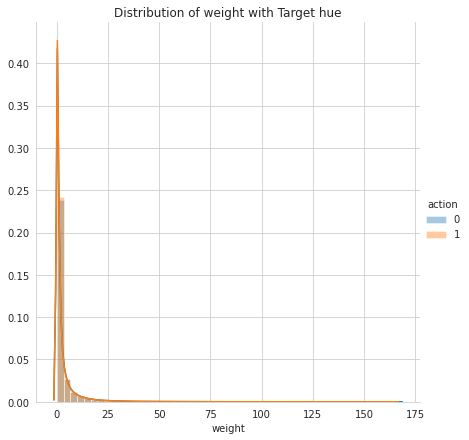

In [ ]:
sns.FacetGrid(train_data,hue='action',size=6).map(sns.distplot,'weight').add_legend()
plt.title('Distribution of weight with Target hue')

From the plot , it can be observed that , weigh value from min. ie. 0.006 to around 25 will provide high chances of investing.

Text(0.5, 1.0, 'Distribution of resp with Target hue')

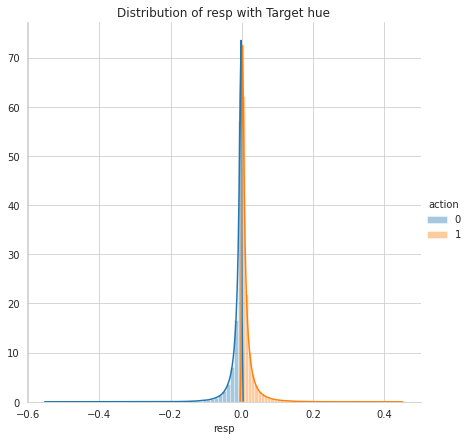

In [ ]:
sns.FacetGrid(train_data,hue='action',size=6).map(sns.distplot,'resp').add_legend()
plt.title('Distribution of resp with Target hue')

Since, the action value is derived from the resp feature itself, it can be obvious that it will contain threshold value, to differentiate among the classes of target.

Text(0.5, 1.0, 'violin Plot of weight feature')

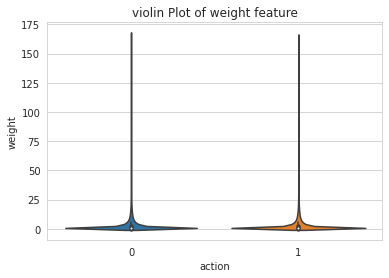

In [ ]:
sns.violinplot(x='action',y='weight',data=train_data,size=6)
plt.title('violin Plot of weight feature')

From the plot it can be observed that the spread of weight feature lies below 25, we con observe using percentile values. 

In [ ]:
for i in range(50,101,10):
  print(f"The {i}th percentile value of weight is {np.percentile(train_data['weight'],i)}")

The 50th percentile value of weight is 0.7086769723734838
The 60th percentile value of weight is 1.1482543673992782
The 70th percentile value of weight is 1.8778745803002612
The 80th percentile value of weight is 3.348321785886576
The 90th percentile value of weight is 7.4001913109007464
The 100th percentile value of weight is 167.2937151011765


In [ ]:
for i in range(90,101,1):
  print(f"The {i}th percentile value of weight is {np.percentile(train_data['weight'],i)}")

The 90th percentile value of weight is 7.4001913109007464
The 91th percentile value of weight is 8.218563577032382
The 92th percentile value of weight is 9.196046357257158
The 93th percentile value of weight is 10.37193489111502
The 94th percentile value of weight is 11.829627869288792
The 95th percentile value of weight is 13.66876622444915
The 96th percentile value of weight is 16.110756692163612
The 97th percentile value of weight is 19.67189522787508
The 98th percentile value of weight is 25.343395162734986
The 99th percentile value of weight is 36.87670108558268
The 100th percentile value of weight is 167.2937151011765


This states that 99% of values lies before weight 40.46.

Text(0.5, 1.0, 'violin Plot of resp feature')

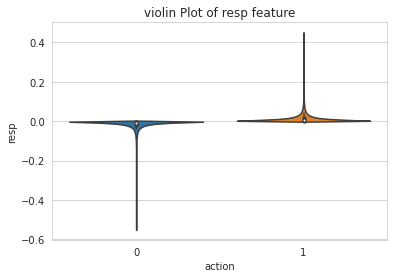

In [ ]:
sns.violinplot(x='action',y='resp',data=train_data,size=6)
plt.title('violin Plot of resp feature')

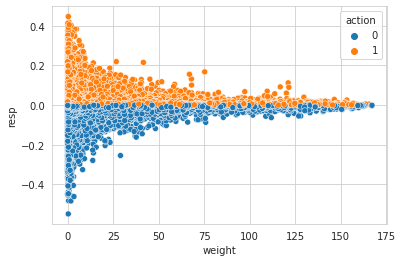

In [ ]:
sns.scatterplot(x = train_data['weight'],y=train_data['resp'],hue=train_data['action'])

## ts_id feature

ts_id represents a time ordering, trades per day

In [ ]:
trades_per_day = train_data.groupby('date')['ts_id'].count()
trades_per_day[:5]

date
0     5587
1     9401
2      231
3     7221
4    10305
Name: ts_id, dtype: int64

Text(0.5, 1.0, 'Distribution of trades per day')

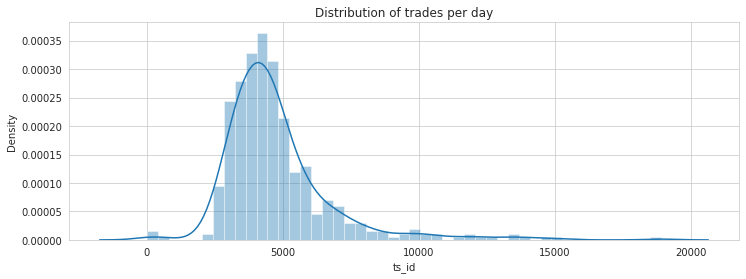

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,4))
sns.distplot(trades_per_day)
plt.title("Distribution of trades per day")

Text(0.5, 1.0, 'Distribution of trades per day')

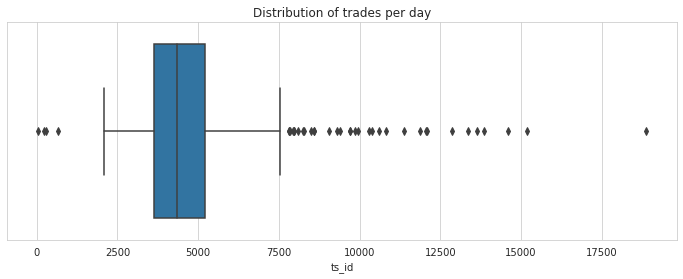

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,4))
sns.boxplot(trades_per_day)
plt.title("Distribution of trades per day")

In [ ]:
print(f"The 25th percentile values for trades per day is {np.percentile(trades_per_day,25)}")
print(f"The 50th percentile values for trades per day is {np.percentile(trades_per_day,50)}")
print(f"The 75th percentile values for trades per day is {np.percentile(trades_per_day,75)}")

The 25th percentile values for trades per day is 3621.0
The 50th percentile values for trades per day is 4353.5
The 75th percentile values for trades per day is 5220.25


From the above description of plot and quantile range we observed that the range of high transaction per day, starts with 3621 to 5220

[]

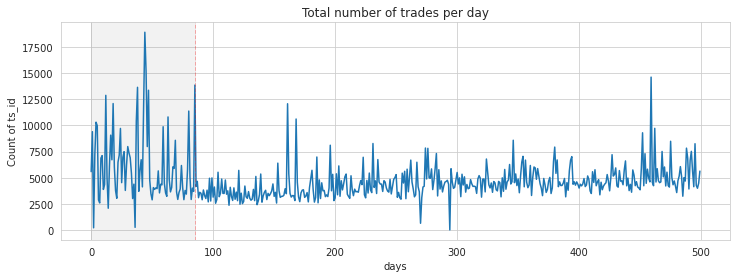

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(trades_per_day)
plt.title("Total number of trades per day")
plt.xlabel("days")
plt.ylabel("Count of ts_id")
plt.axvline(x=85, linestyle='--', alpha=0.3, c='red', lw=1)
plt.axvspan(0,85 , color='grey', alpha=0.1)
plt.plot()

By looking at the plot we observe that the fluctuation is in the range 0-100, and at last around after 450 to 500, and almost all of the days having a large volume of trades are before and up to day 85.

Referred from : https://www.investopedia.com/terms/v/volatility.asp, It is extracted out that Volatility is the measure of fluctuations, Volatile assets are often considered riskier than less volatile assets because the price is expected to be less predictable,Volatility is an important variable for calculating options prices.

As Suggested in the mentioned link, higher number of trades for a given day simply indicates higher market volatility.

Referred from : https://www.kaggle.com/c/jane-street-market-prediction/discussion/201930#1125847,
more than 9k trades per day and almost all of them occur before day 85


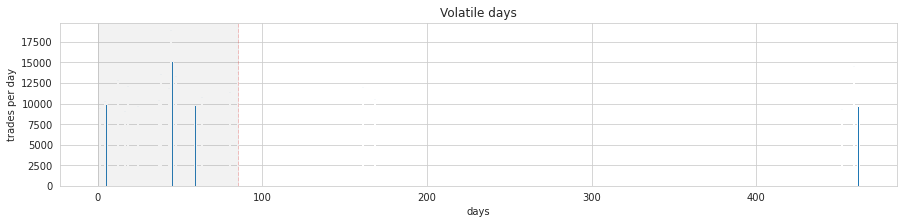

In [ ]:
#to find volatile days
plt.figure(figsize=(15,3))
volatile_days = dict(trades_per_day[trades_per_day >9000])
days = volatile_days.keys()
transaction = volatile_days.values()
plt.bar(days,transaction)
plt.axvline(85,color='red',ls='--',lw=1,alpha=0.2)
plt.axvspan(0,85,color='grey',alpha=0.1)
plt.title('Volatile days')
plt.xlabel('days')
plt.ylabel('trades per day')
plt.show()

Mostly the number of transactions per day ranges from 2500 to 7500. It will be good to have sample days one from lesser-transactions-day and another from more-transaction-day to have better understanding on handling missing values

So for feature engineering and feature designing, we can use all the dates which have enough number of transactions, suitably lying in quanitle range.

Awesome. Irrespective of number of transactions, missing values do have the same pattern based on time. (It is true to even highest number of transactions day; I tested with date=44).

So missing values should not be
*  filled with mean values or nanmean values
*  filled with any kind of ffill method or something
*  dropped

As we can observe that higher volatile days are previous to days 85, Therefore considering first 85 days will give a better training to the model.

Text(0.5, 1.0, 'Ditribution of ts_id with action hue')

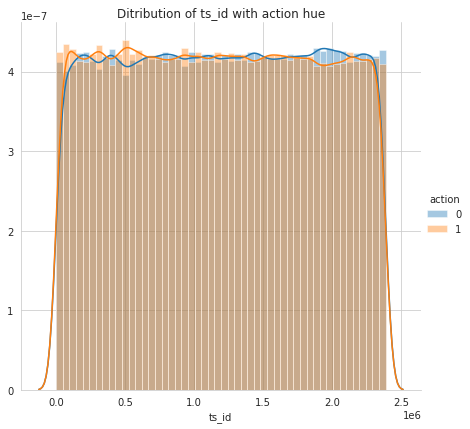

In [ ]:
sns.FacetGrid(train_data,hue='action',size=6).map(sns.distplot,'ts_id').add_legend()
plt.title('Ditribution of ts_id with action hue')

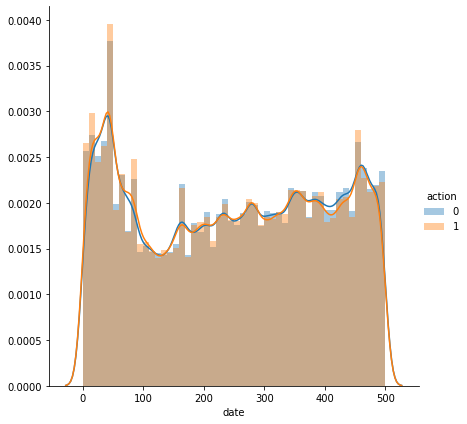

In [ ]:
sns.FacetGrid(train_data,hue = 'action',size=6).map(sns.distplot,'date').add_legend()

## Observations uptill now:
We have observed uptill now that 
* Transaction before 85 days will be usefull to train the model
* The action can be decided from weight and resp as mentioned in the data descriptiton


Since we have feature 0-129, which are too many features, we will do feature selection to select top 15 features and then see how these features impact the target variable.

# 129 features

In [ ]:
train_data[feature_columns].head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,...,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129
0,1,-1.872746,-2.191242,-0.474163,-0.323046,0.014688,-0.002484,NaN,NaN,-0.989982,-1.055090,NaN,NaN,-2.667671,-2.001475,-1.703595,-2.196892,NaN,NaN,1.483295,1.307466,NaN,NaN,1.175200,0.967805,1.608410,1.319365,NaN,NaN,-0.515073,-0.448988,NaN,NaN,-2.429812,-2.206423,-3.593120,-2.868358,0.112697,0.053157,-0.539956,...,NaN,1.158770,NaN,3.754522,7.137163,-1.863069,NaN,0.434466,NaN,-0.292035,0.317003,-2.605820,NaN,2.896986,NaN,1.485813,4.147254,-2.238831,NaN,-0.892724,NaN,-0.156332,0.622816,-3.921523,NaN,2.561593,NaN,3.457757,6.649580,-1.472686,NaN,NaN,1.168391,8.313583,1.782433,14.018213,2.653056,12.600292,2.301488,11.445807
1,-1,-1.349537,-1.704709,0.068058,0.028432,0.193794,0.138212,NaN,NaN,-0.151877,-0.384952,NaN,NaN,1.225838,0.789076,1.110580,1.102281,NaN,NaN,-0.590600,-0.625682,NaN,NaN,-0.543425,-0.547486,-0.706600,-0.667806,NaN,NaN,0.910558,0.914465,NaN,NaN,2.137454,2.080459,2.819291,2.483965,-0.086755,-0.082687,0.368431,...,NaN,1.157671,NaN,1.297679,1.281956,-2.427595,NaN,0.024913,NaN,-0.413607,-0.073672,-2.434546,NaN,0.949879,NaN,0.724655,1.622137,-2.209020,NaN,-1.332492,NaN,-0.586619,-1.040491,-3.946097,NaN,0.983440,NaN,1.357907,1.612348,-1.664544,NaN,NaN,-1.178850,1.777472,-0.915458,2.831612,-1.417010,2.297459,-1.304614,1.898684
2,-1,0.812780,-0.256156,0.806463,0.400221,-0.614188,-0.354800,NaN,NaN,5.448261,2.668029,NaN,NaN,3.836342,2.183258,3.902698,3.045431,NaN,NaN,-1.141082,-0.979962,NaN,NaN,-1.157585,-0.966803,-1.430973,-1.103432,NaN,NaN,5.131559,4.314714,NaN,NaN,4.226341,3.173640,5.991513,4.142298,-0.167927,-0.124778,0.749326,...,NaN,2.420089,NaN,0.800962,1.143663,-3.214578,NaN,1.585939,NaN,0.193996,0.953114,-2.674838,NaN,2.200085,NaN,0.537175,2.156228,-3.568648,NaN,1.193823,NaN,0.097345,0.796214,-4.090058,NaN,2.548596,NaN,0.882588,1.817895,-2.432424,NaN,NaN,6.115747,9.667908,5.542871,11.671595,7.281757,10.060014,6.638248,9.427299
3,-1,1.174378,0.344640,0.066872,0.009357,-1.006373,-0.676458,NaN,NaN,4.508206,2.484260,NaN,NaN,2.902176,1.799163,3.192700,2.848359,NaN,NaN,-1.401637,-1.428248,NaN,NaN,-1.421175,-1.487976,-1.756415,-1.647543,NaN,NaN,4.766182,4.528353,NaN,NaN,3.330068,2.778468,5.603940,4.343171,-0.203161,-0.177835,0.642206,...,NaN,2.330484,NaN,0.182066,1.088451,-3.527752,NaN,-1.338859,NaN,-1.257774,-1.194013,-1.719062,NaN,-0.940190,NaN,-1.510224,-1.781693,-3.373969,NaN,2.513074,NaN,0.424964,1.992887,-2.616856,NaN,0.561528,NaN,-0.994041,0.099560,-2.485993,NaN,NaN,2.838853,0.499251,3.033732,1.513488,4.397532,1.266037,3.856384,1.013469
4,1,-3.172026,-3.093182,-0.161518,-0.128149,-0.195006,-0.143780,NaN,NaN,2.683018,1.450991,NaN,NaN,1.257761,0.632336,0.905204,0.575275,NaN,NaN,2.550883,2.484082,NaN,NaN,2.502828,2.606440,2.731251,2.566561,NaN,NaN,-1.477905,-1.722451,NaN,NaN,-1.191981,-1.037629,-2.237275,-1.740456,0.326904,0.221809,-0.187586,...,NaN,4.345282,NaN,2.737738,2.602937,-1.785502,NaN,-0.172561,NaN,-0.299516,-0.420021,-2.354611,NaN,0.762192,NaN,1.598620,0.623132,-1.742540,NaN,-0.934675,NaN,-0.373013,-1.213540,-3.677787,NaN,2.684119,NaN,2.861848,2.134804,-1.279284,NaN,NaN,0.344850,4.101145,0.614252,6.623456,0.800129,5.233

Looking at the head or few elements of features, it can be observed that feature_0 has only 1 and -1 as its values, which can be looked into, while feature_7,8,120,121 are NaN, which gives an intution that there can be multiple missing values

It is confirmed that feature_0 has only two values as 1 and -1, it is a binary feature which might be a useful observation, meanwhile we will look for explaination from other features.

A better option is we can plot each feature with its realation to the target and its box plot with target hue.

In [ ]:
def plot_features(df1,target='action',features=[]):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(1,5,figsize=(20,3))    
    for feature in features:
        i += 1
        plt.subplot(1,5,i)
        sns.distplot(df1[df1[target]==1][feature].values,label='1')
        sns.distplot(df1[df1[target]==0][feature].values,label='0')
        plt.xlabel(feature, fontsize=9)
        plt.legend() 
    plt.show()

<Figure size 432x288 with 0 Axes>

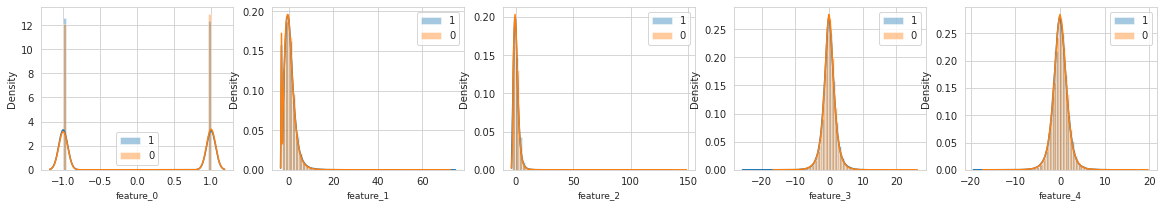

<Figure size 432x288 with 0 Axes>

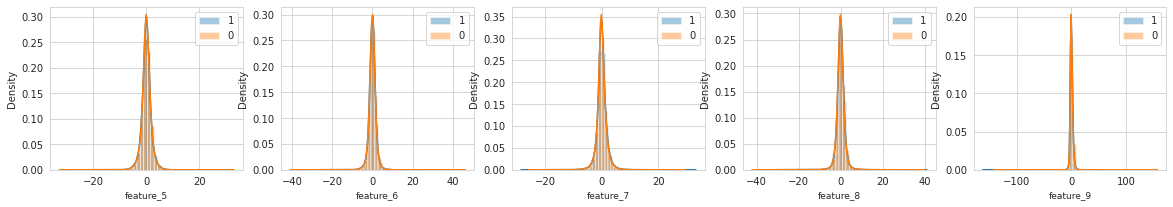

<Figure size 432x288 with 0 Axes>

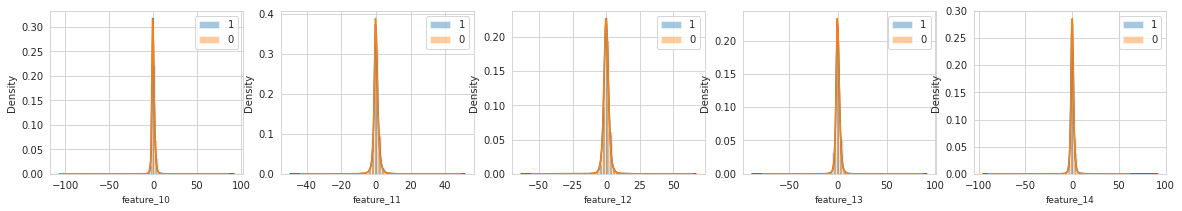

<Figure size 432x288 with 0 Axes>

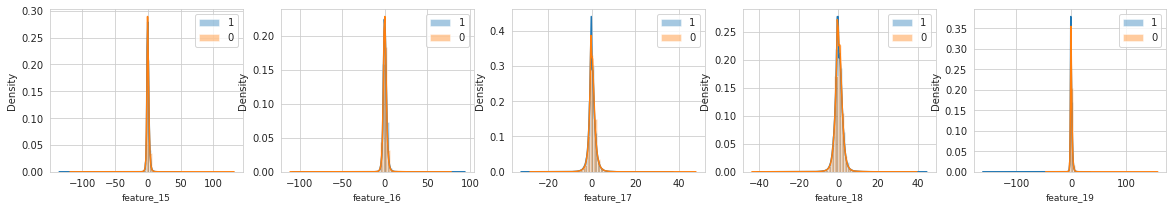

<Figure size 432x288 with 0 Axes>

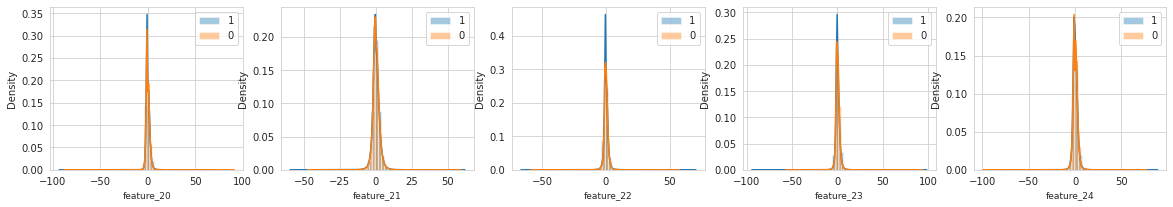

<Figure size 432x288 with 0 Axes>

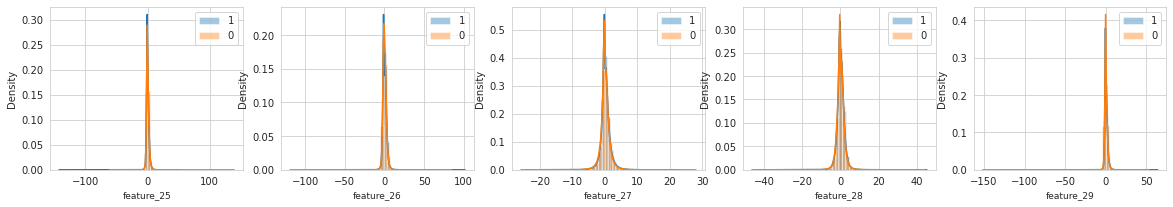

<Figure size 432x288 with 0 Axes>

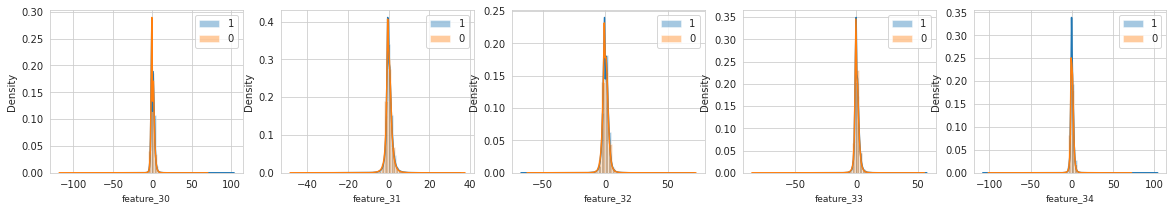

<Figure size 432x288 with 0 Axes>

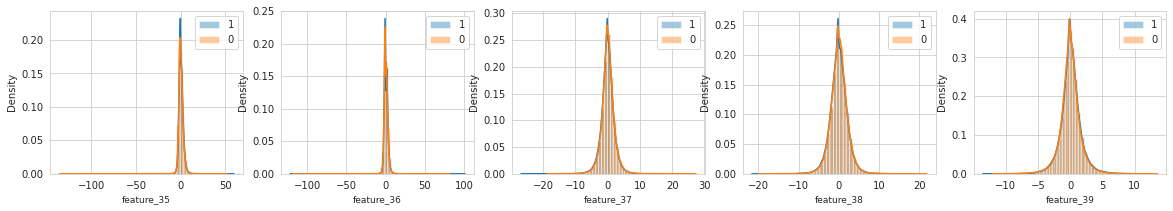

<Figure size 432x288 with 0 Axes>

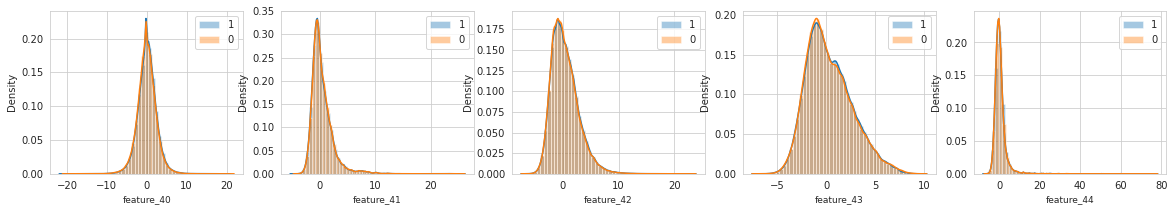

<Figure size 432x288 with 0 Axes>

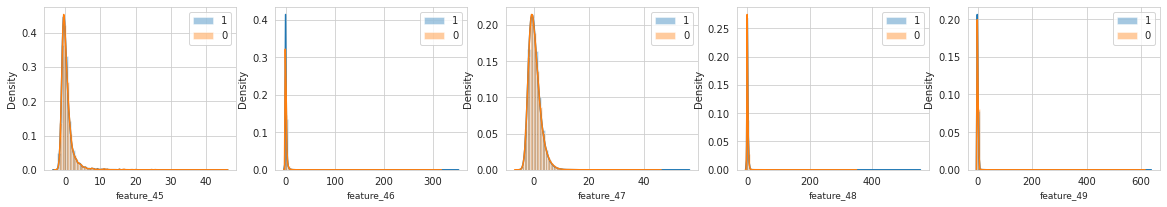

<Figure size 432x288 with 0 Axes>

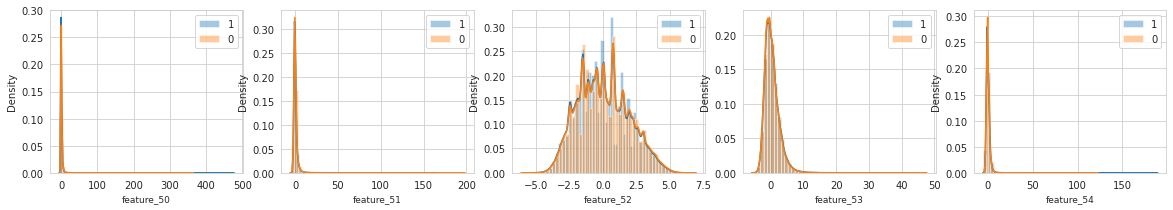

<Figure size 432x288 with 0 Axes>

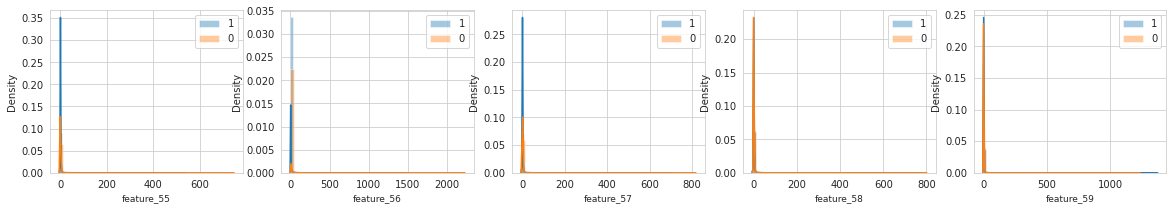

<Figure size 432x288 with 0 Axes>

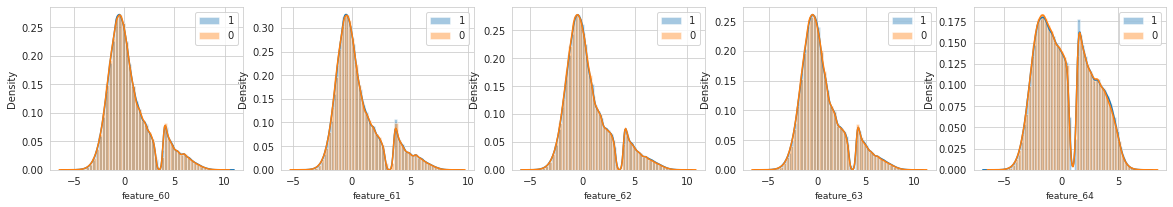

<Figure size 432x288 with 0 Axes>

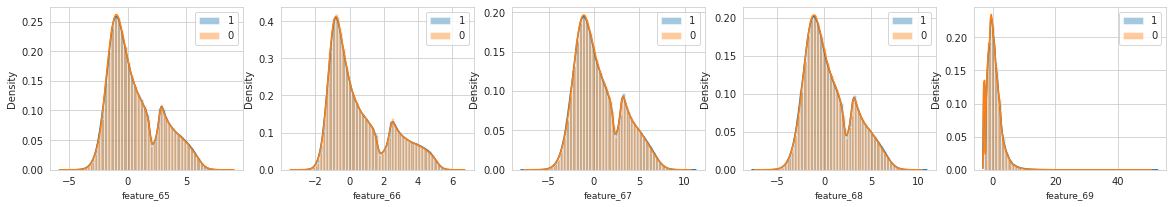

<Figure size 432x288 with 0 Axes>

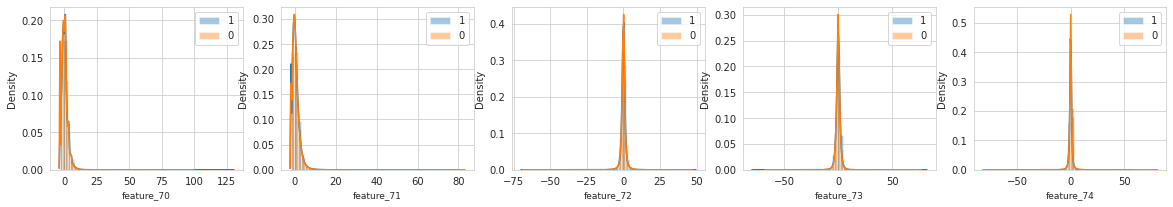

<Figure size 432x288 with 0 Axes>

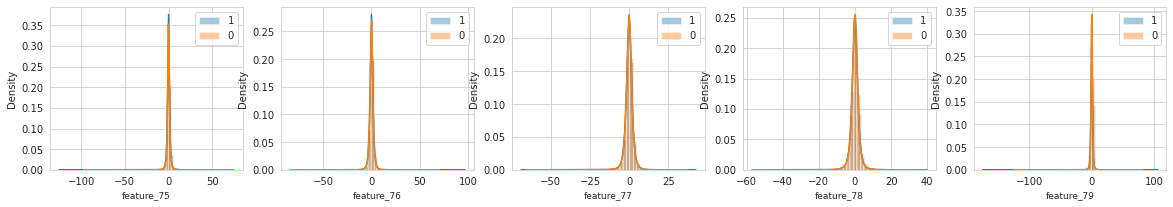

<Figure size 432x288 with 0 Axes>

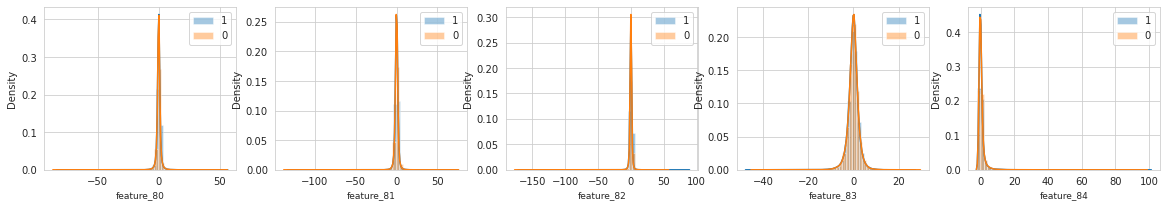

<Figure size 432x288 with 0 Axes>

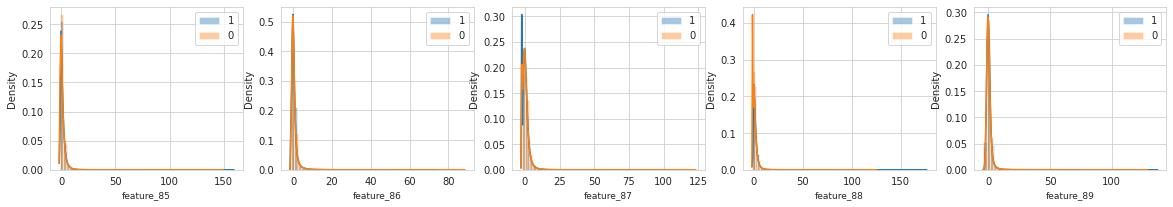

<Figure size 432x288 with 0 Axes>

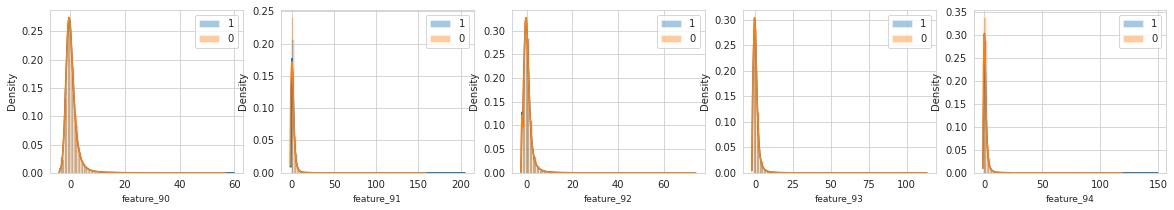

<Figure size 432x288 with 0 Axes>

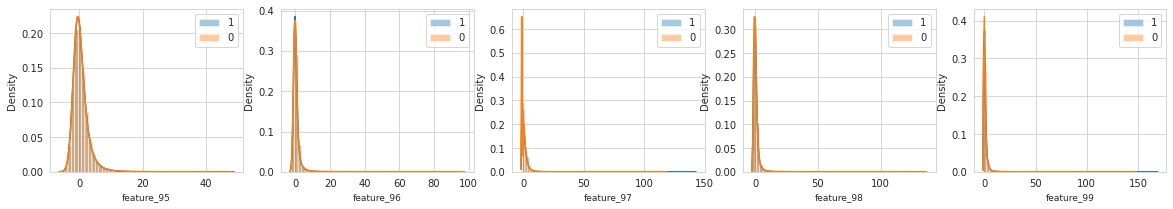

<Figure size 432x288 with 0 Axes>

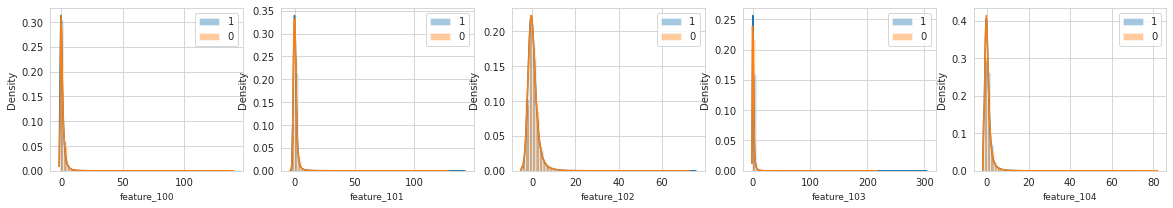

<Figure size 432x288 with 0 Axes>

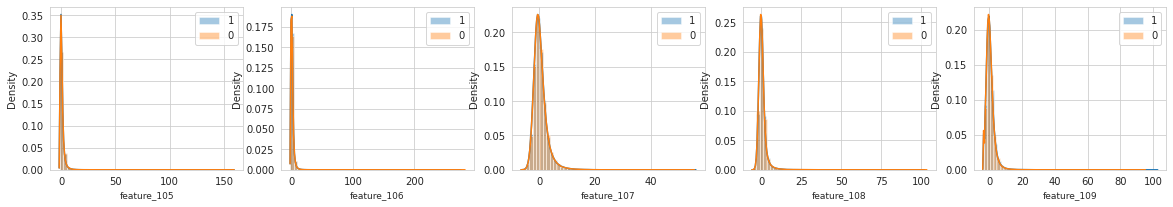

<Figure size 432x288 with 0 Axes>

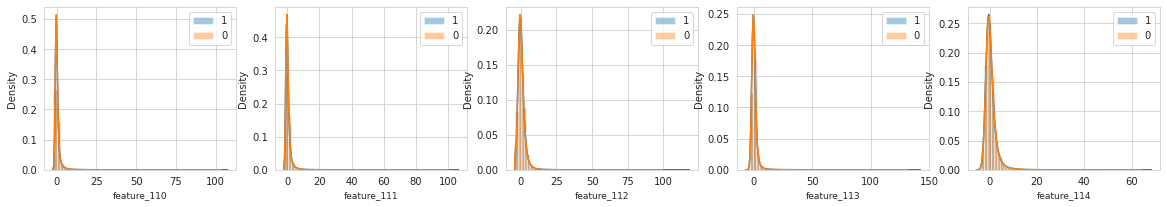

<Figure size 432x288 with 0 Axes>

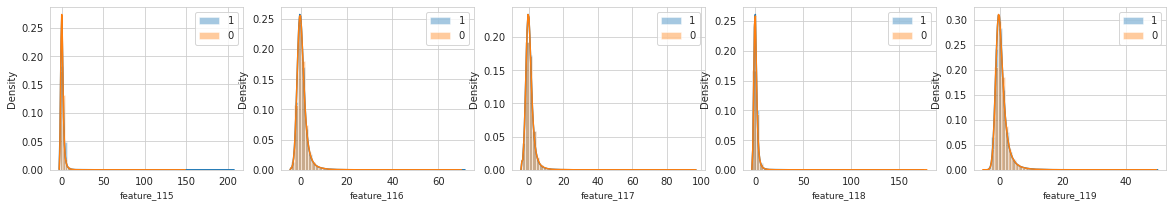

<Figure size 432x288 with 0 Axes>

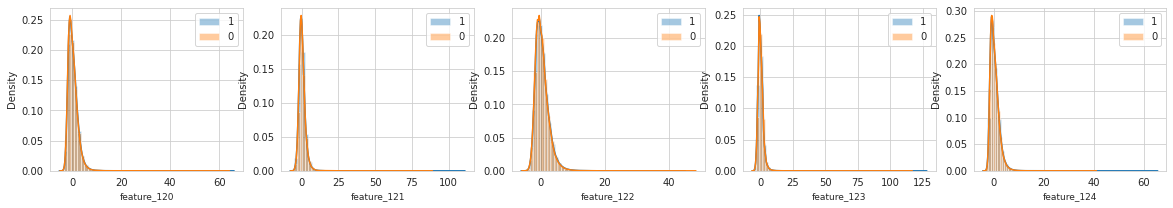

<Figure size 432x288 with 0 Axes>

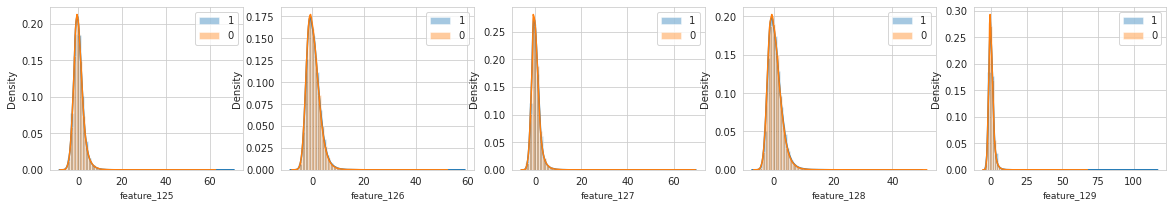

In [ ]:
for j in range(1,int(len(feature_columns)/5)+1):
    plot_features(train_data,target='action',features=train_data[feature_columns[5*(j-1):5*j]])

**Observations from the plots**


*   All features are normally distributed with mostly mean around zero
*   Most Features appears to be correlated

To have a better understanding we can plot correlation matrix.



Let us understand spread of each plot

In [ ]:
feature_description = train_data[feature_columns].describe()
percentile99=[]
percentile99point9=[]
differencemax99=[]
for i in tqdm(feature_columns):
    percentile99.append(np.percentile(train_data[i],(0,99)))
    percentile99point9.append(np.percentile(train_data[i],(0,99.9)))
    differencemax99.append(train_data[i].max() - np.percentile(train_data[i],99.9))
feature_description.loc['99 %'] = percentile99
feature_description.loc['99.9 %'] = percentile99point9
feature_description.loc['difference_'] = differencemax99
feature_description

100%|██████████| 130/130 [00:09<00:00, 13.60it/s]


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,...,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129
count,2.39049e+06,2.39049e+06,2.39049e+06,2.39004e+06,2.39004e+06,2.39049e+06,2.39049e+06,1.99736e+06,1.99736e+06,2.3897e+06,2.3897e+06,2.31048e+06,2.31048e+06,2.37514e+06,2.37514e+06,2.38381e+06,2.38381e+06,1.99496e+06,1.99496e+06,2.3897e+06,2.3897e+06,2.30905e+06,2.30905e+06,2.37514e+06,2.37514e+06,2.38381e+06,2.38381e+06,1.99496e+06,1.99496e+06,2.3897e+06,2.3897e+06,2.30905e+06,2.30905e+06,2.37514e+06,2.37514e+06,2.38381e+06,2.38381e+06,2.39049e+06,2.39049e+06,2.39049e+06,...,2.03906e+06,2.3897e+06,2.3264e+06,2.37514e+06,2.38381e+06,2.39049e+06,2.03906e+06,2.3897e+06,2.3264e+06,2.37514e+06,2.38381e+06,2.39049e+06,2.03906e+06,2.3897e+06,2.3264e+06,2.37514e+06,2.38381e+06,2.39049e+06,2.03906e+06,2.3897e+06,2.3264e+06,2.37514e+06,2.38381e+06,2.39049e+06,2.03906e+06,2.3897e+06,2.3264e+06,2.37514e+06,2.38381e+06,2.39049e+06,2.32064e+06,2.32064e+06,2.39027e+06,2.39027e+06,2.37441e+06,2.37441e+06,2.38164e+06,2.38164e+06,2.38857e+06,2.38857e+06
mean,0.00983856,0.385578,0.357687,0.00891917,0.00415006,-0.00371462,-0.0125892,0.0517766,0.0268281,0.248813,0.182349,0.0891216,0.0494855,0.143105,0.0890272,0.211678,0.146301,0.121219,0.113582,0.293815,0.268768,0.186911,0.176979,0.252441,0.238561,0.294071,0.273178,0.135483,0.160876,0.321892,0.342534,0.22056,0.250131,0.308222,0.335353,0.341453,0.365825,0.0293205,0.0228918,0.0400216,...,0.410253,0.520512,0.405081,0.40883,0.428894,0.417632,0.402268,0.559095,0.407107,0.436857,0.500123,0.408565,0.405063,0.481406,0.401656,0.407061,0.453045,0.415012,0.399993,0.416541,0.400736,0.406878,0.412285,0.402637,0.407112,0.373417,0.404433,0.401033,0.385817,0.4156,0.335127,0.268776,0.343552,0.279997,0.335154,0.244875,0.339178,0.232381,0.342561,0.245618
std,0.999952,2.55937,2.47734,1.93933,1.75111,1.73408,1.68434,1.76833,2.0261,2.40061,1.73147,1.68054,2.44984,2.27418,2.06539,1.88531,2.25881,1.72089,2.23314,1.70622,1.95525,2.46394,1.86642,2.13532,2.66248,2.07705,2.33102,1.52379,2.08246,1.72962,2.1085,1.70769,2.57009,1.94578,2.12044,2.41905,2.32164,2.03392,2.13646,1.58919,...,2.27246,2.69875,2.09912,2.21208,2.11688,2.51483,2.27522,2.5771,2.3359,2.11873,2.2672,2.58384,2.54431,2.21872,1.87308,2.08903,2.73541,2.49722,2.62737,2.58701,2.00547,1.95178,2.60447,2.86021,2.29741,2.32035,2.35906,2.51255,2.37981,2.07317,1.90638,2.17424,2.08784,1.97764,1.74259,2.24285,2.5345,1.79585,2.30713,1.76542
min,-1,-3.17203,-3.09318,-25.4247,-19.1188,-32.5223,-40.7389,-28.1594,-41.8812,-161.569,-106.57,-49.2906,-62.8339,-87.5318,-95.303,-134.593,-110.78,-32.1355,-43.3565,-160.404,-92.7367,-59.198,-66.1236,-93.7114,-98.9491,-141.453,-118.489,-25.5537,-45.858,-151.171,-117.743,-48.2644,-66.7098,-85.0946,-107.537,-135.335,-121.428,-26.4982,-21.2205,-13.2816,...,-3.57269,-1.51561,-2.11589,-1.74629,-1.08689,-5.85394,-2.62735,-1.33886,-2.17554,-1.25777,-1.19401,-3.5014,-4.66085,-0.94019,-1.65223,-1.51022,-1.78169,-5.98412,-5.42771,-3.54845,-1.9901,-1.83887,-3.80734,-6.48028,-5.10648,-2.92263,-4.29108,-4.15927,-3.20249,-5.10115,-4.88349,-7.47197,-5.86298,-6.02928,-4.08072,-8.13641,-8.21505,-5.76598,-7.02491,-5.28218
25%,-1,-1.29933,-1.26363,-1.02387,-0.97

it can be infered from following observation that feature contains outliers, we can remove them...

## variance Engineering

In [ ]:
feature_data_corr = pd.concat([train_data[feature_columns],train_data['action']],axis=1).corr()

Text(0.5, 1.0, 'Correlation heat map of feature columns')

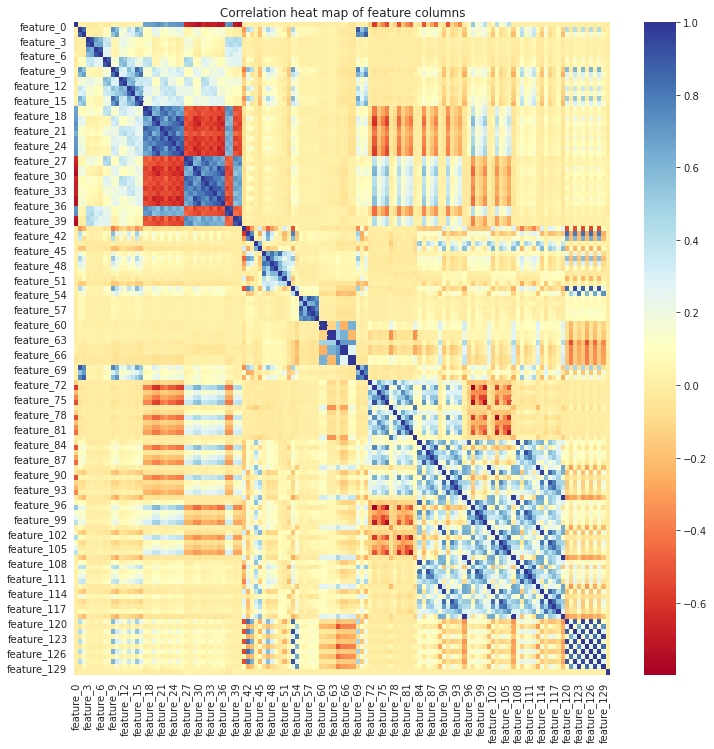

In [ ]:
plt.figure(figsize =(12,12))
sns.heatmap(feature_data_corr,cmap='RdYlBu')
plt.title("Correlation heat map of feature columns")

Observing the heat map we can see a bunch from feature 16-40 appears to be highly correlated, we can investigate in depth and if we find high correalation we can drop the features

[]

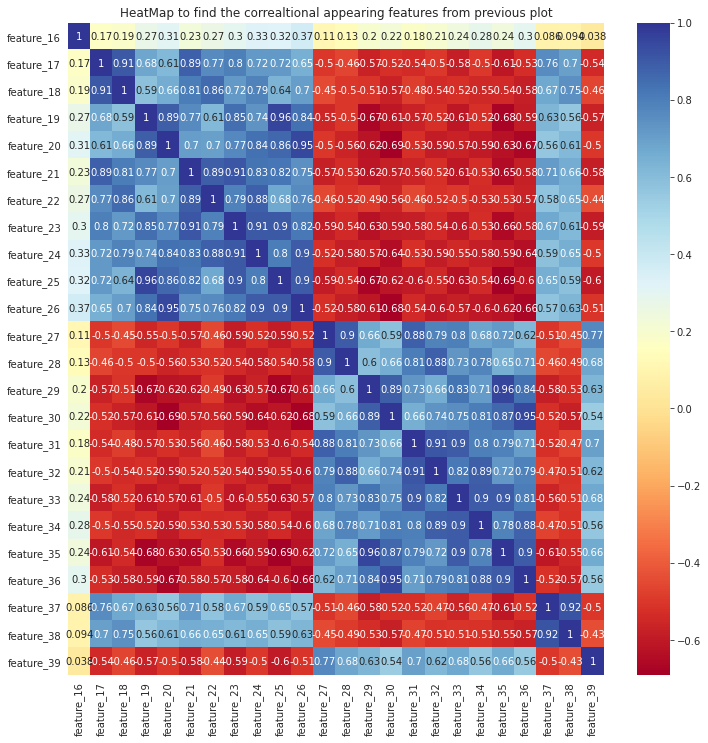

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(feature_data_corr.iloc[16:40,16:40],cmap='RdYlBu',annot=True)
plt.title("HeatMap to find the correaltional appearing features from previous plot")
plt.plot()

We can utilize the concept , and can drop all the features which are highly correlated

In [ ]:
print(f"The minimum value of correaltion starts with {min(feature_data_corr.min())}")
print(f"The maximum value of correaltion starts with {max(feature_data_corr.max())}")

The minimum value of correaltion starts with -0.7979575916416414
The maximum value of correaltion starts with 1.0


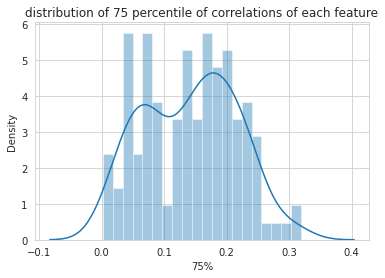

In [ ]:
plt.title("distribution of 75 percentile of correlations of each feature")
sns.distplot(feature_data_corr.describe().iloc[6],bins=20)

From the distribution of means of correlations , we can observe that most values lie below around 0.32, so we can set this to be a threshold, but we will take 0.5 so as to not loose some columns.

In [ ]:
th =0.5
correlated_features = set()
ListCorrelatedwithTarget = dict(feature_data_corr["action"].sort_values(ascending=False)[:10])
for i in range(len(feature_data_corr.columns)):
    for j in range(i):
        if abs(feature_data_corr.iloc[i, j]) > th and i not in list(ListCorrelatedwithTarget.keys()):
            colname = feature_data_corr.columns[i]
            correlated_features.add(colname)

In [ ]:
uncorrelated_data = train_data[feature_columns].drop(correlated_features,axis=1)

In [ ]:
uncorrelated_data = pd.concat([uncorrelated_data,train_data['action']],axis=1)

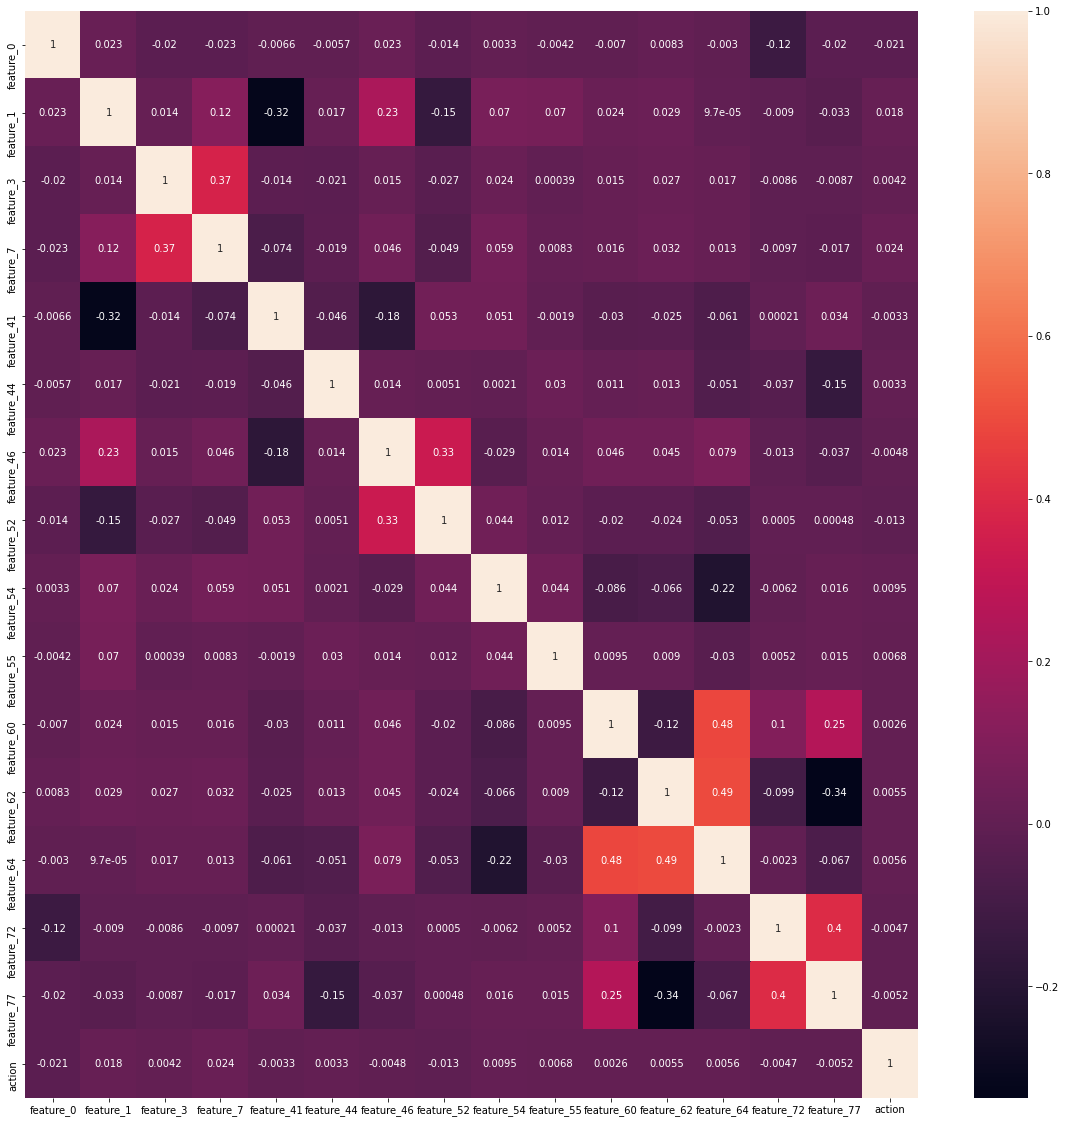

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(uncorrelated_data.corr(),annot=True)

All these features are although un correlated to each other but with the output also,, these do not have a good correlation, which means, these features are not good enough to predict the action, but we can utilize them based on comparison with the features after dimentionality reduction.

<Figure size 432x288 with 0 Axes>

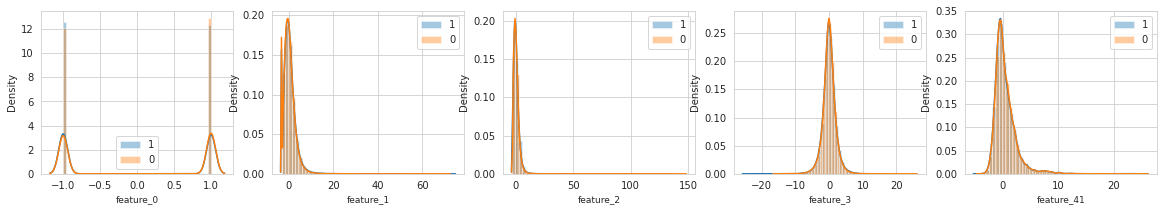

<Figure size 432x288 with 0 Axes>

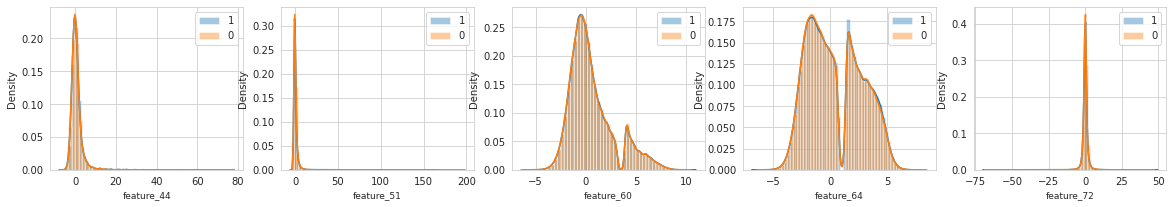

In [ ]:
for j in range(1,int(len(uncorrelated_data.columns)/5)+1):
    plot_features(train_data,target='action',features=uncorrelated_data[uncorrelated_data.columns[5*(j-1):5*j]])

We observe that after dropping of correlative features, from the main train data set, all the uniquely spreaded features are formed out, and these features can be utilized.

## Missing Values

In [ ]:
train_data['feature_0'].value_counts()

 1    1207005
-1    1183486
Name: feature_0, dtype: int64

It is confirmed that feature_0 has only two values as 1 and -1, it is a binary feature which might be a useful observation, meanwhile we will look for explaination from other features.

Let us plot for the percentage of missing values with each feature,since we have massive data, to avoid crashing we will observe 129 features in 5 sub plots

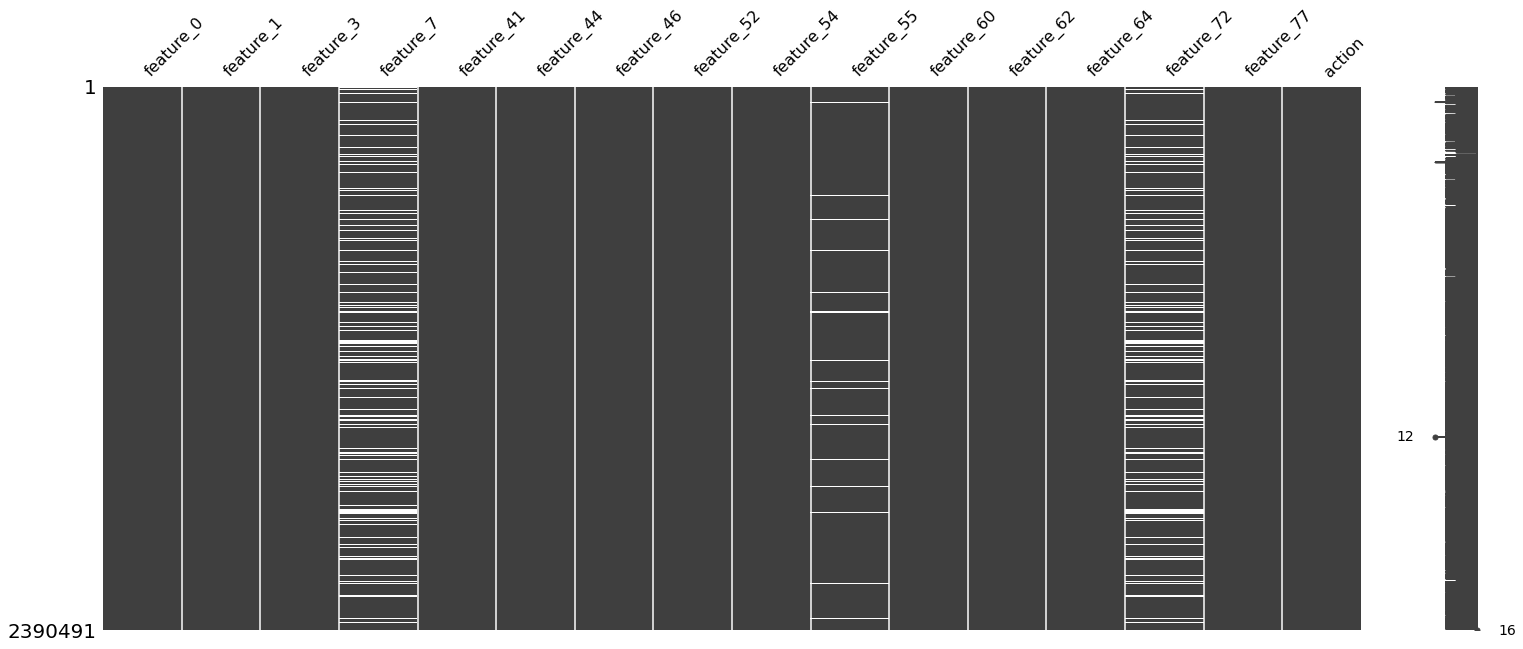

In [ ]:
msno.matrix(uncorrelated_data)

In [ ]:
missing_percentage={}
for col in train_data.columns:
    missing_percentage[col] = (sum(train_data[col].isna())/len(train_data[col]))*100
missing_data = pd.DataFrame(sorted(missing_percentage.items(),key=operator.itemgetter(1),reverse=True),columns=['feature','Missing %'])
del missing_percentage
missing_data.head(10)

,feature,Missing %
0,feature_17,16.546182
1,feature_18,16.546182
2,feature_27,16.546182
3,feature_28,16.546182
4,feature_7,16.445785
5,feature_8,16.445785
6,feature_72,14.700997
7,feature_78,14.700997
8,feature_84,14.700997
9,feature_90,14.700997


To vizualize the data with missing values

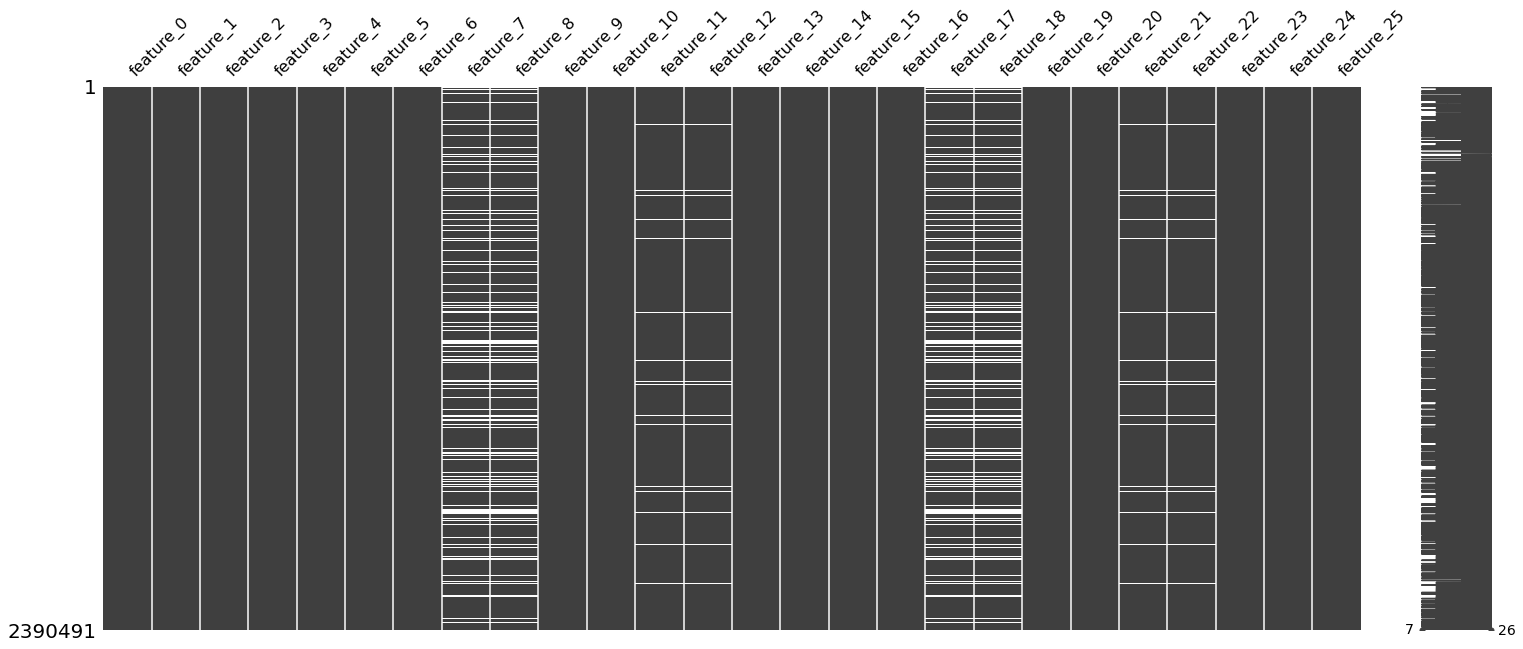

In [ ]:
# https://www.geeksforgeeks.org/python-visualize-missing-values-nan-values-using-missingno-library/
msno.matrix(train_data[feature_columns[:26]])

Observing missing values in feature ranging from 0,26 we see feature 7,8,17,18 have a lot of missing values, while,11,12,21 and 22 have less missing values. 

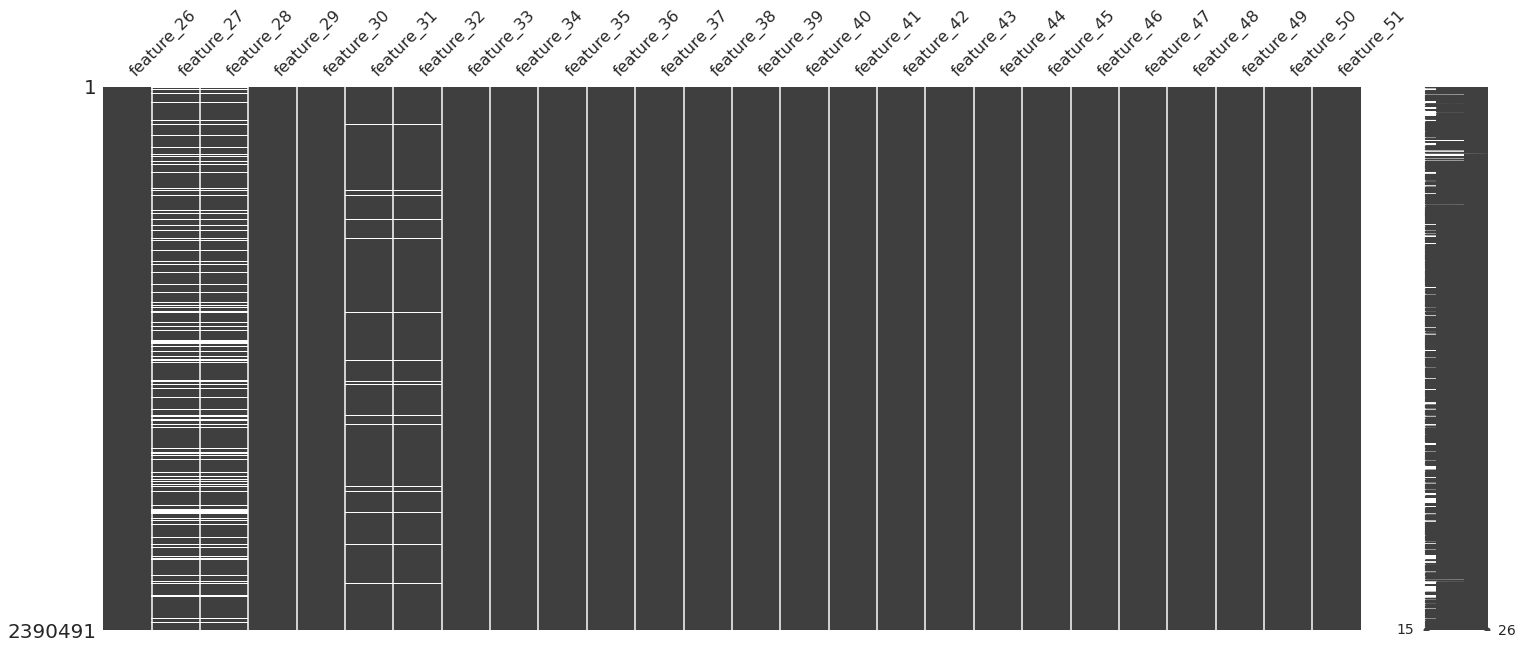

In [ ]:
msno.matrix(train_data[feature_columns[26:52]])

Observing missing values in feature ranging from 26 to 52 we see feature 27,28 have a lot of missing values, while 31 and 32 have less missing values. 

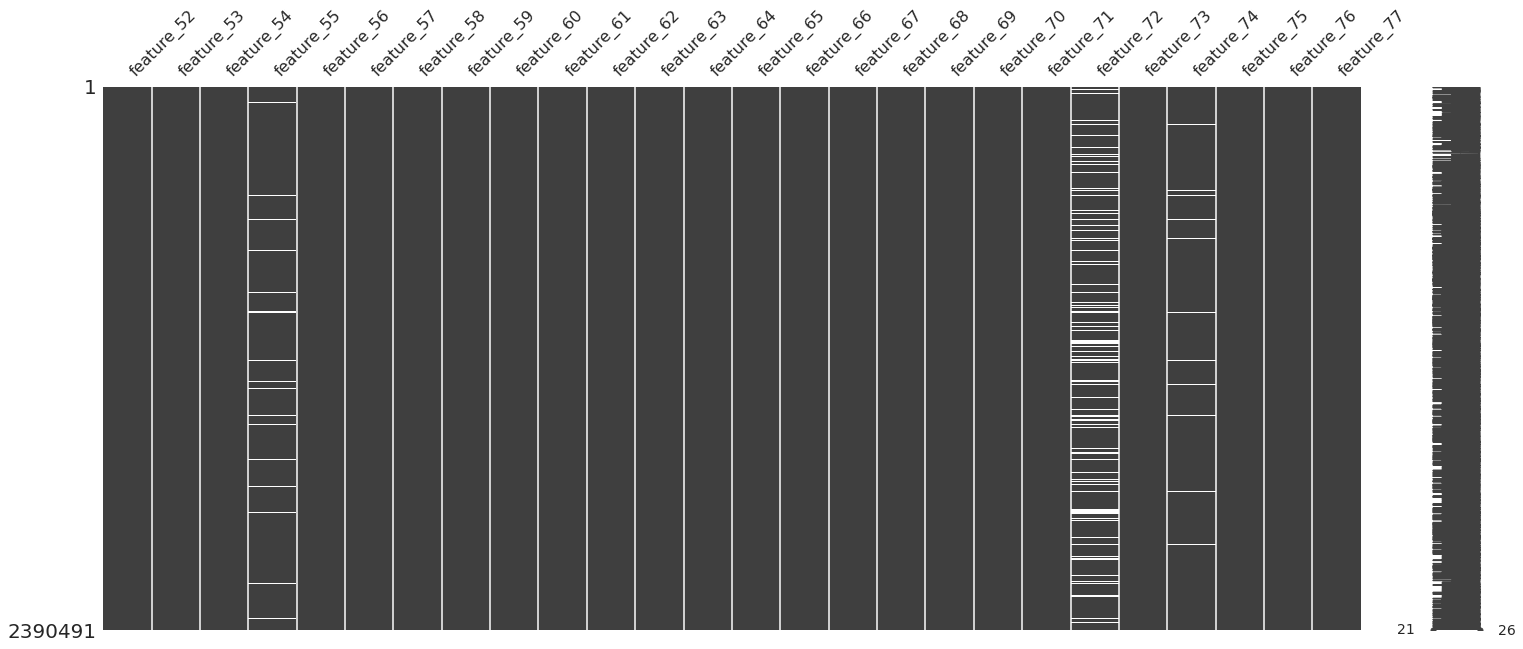

In [ ]:
msno.matrix(train_data[feature_columns[52:78]])

Observing missing values in feature ranging from 52 to 78 we see feature 72 have a lot of missing values, while 55 and 74 have less missing values

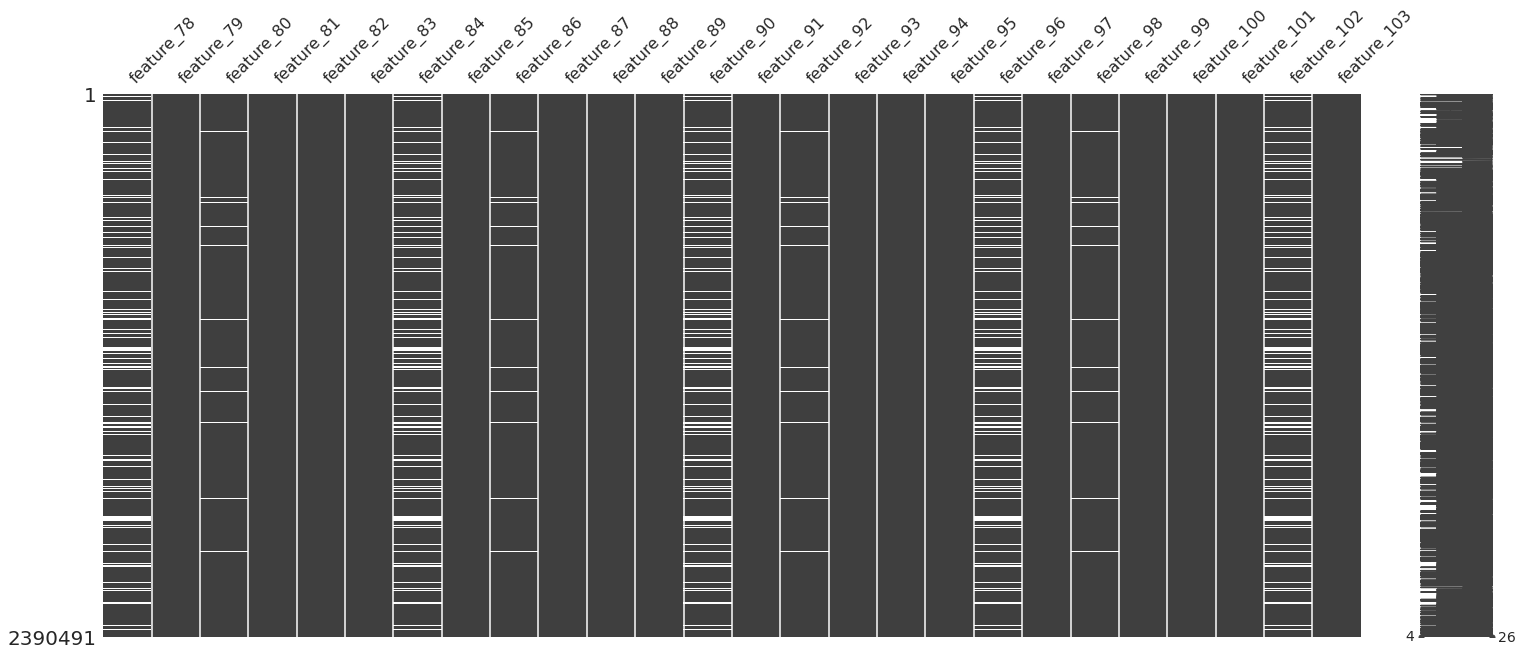

In [ ]:
msno.matrix(train_data[feature_columns[78:104]])

Observing missing values in feature ranging from 78 to 104 we see feature 78,84,90,96,102 have a lot of missing values, while 80,86,92 and 98 have less missing values. 

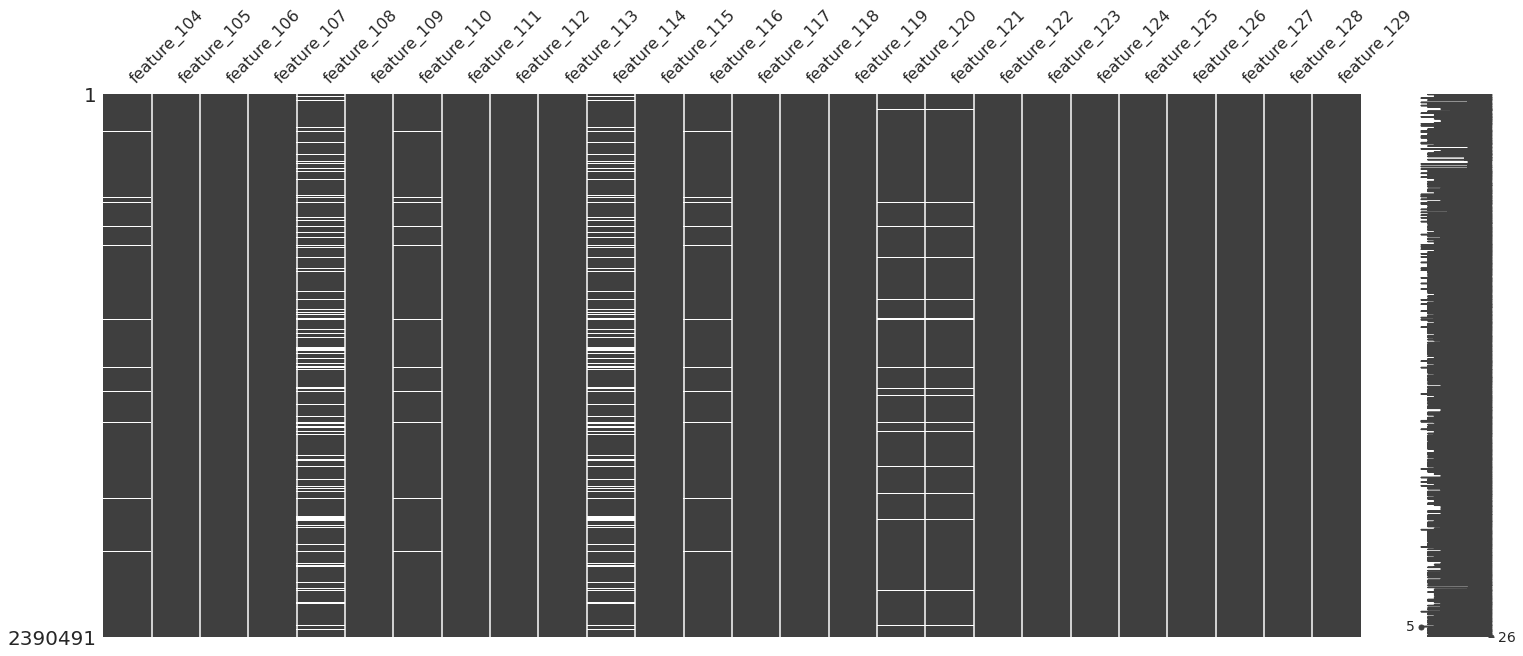

In [ ]:
msno.matrix(train_data[feature_columns[104:130]])

Observing missing values in feature ranging from 104 to 129 we see feature 108 and 114 have a lot of missing values, while 104,110,116,120 and 121 have less missing values. 

On complete observation of missing plot we observe that , we have features -
* 7,8,17,18,11,12,21,22,27,28,78,84,90,96,102,80,86,92,98,108,114,104,110,116,120,121

which have missing values,
Now let us see the count of missing values in the mentioned list of columns.

[]

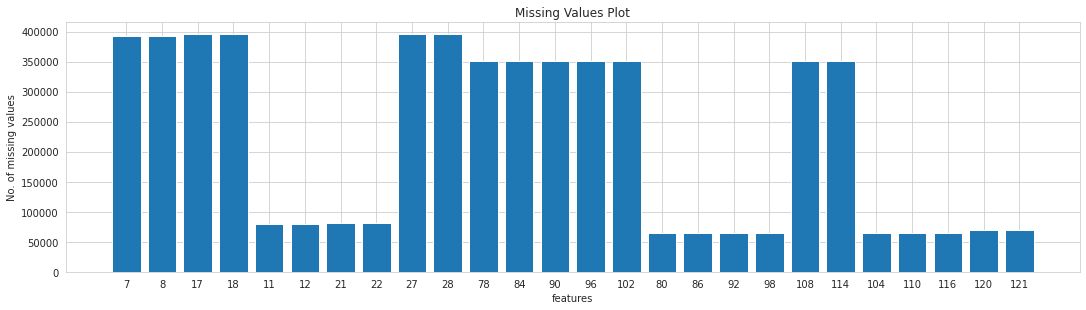

In [ ]:
missing_values_in={}
list_missing_features = [7,8,17,18,11,12,21,22,27,28,78,84,90,96,102,80,86,92,98,108,114,104,110,116,120,121]
for featNo in list_missing_features:
    feature = f'feature_{featNo}'
    missing_values_in[f'{featNo}']= sum(train_data[feature].isna())
plt.figure(figsize=(15,4))
plt.bar(missing_values_in.keys(),missing_values_in.values())
plt.tight_layout()
plt.xlabel('features')
plt.ylabel('No. of missing values')
plt.title('Missing Values Plot')
plt.plot()

we can observe from the plot that out of 2390491 values if we consider approx 350000 values missing from the data set, we can not remove the feature as the ratio of missing value is very less around only 16% of the data, as mentioned in the below calculation.

Instead we will be filling those values with the median of the particular feature.

From the discussion [here](https://www.kaggle.com/c/jane-street-market-prediction/discussion/201264), we find that there is a missing pattern for day 0, 96,242,450 and 454. 

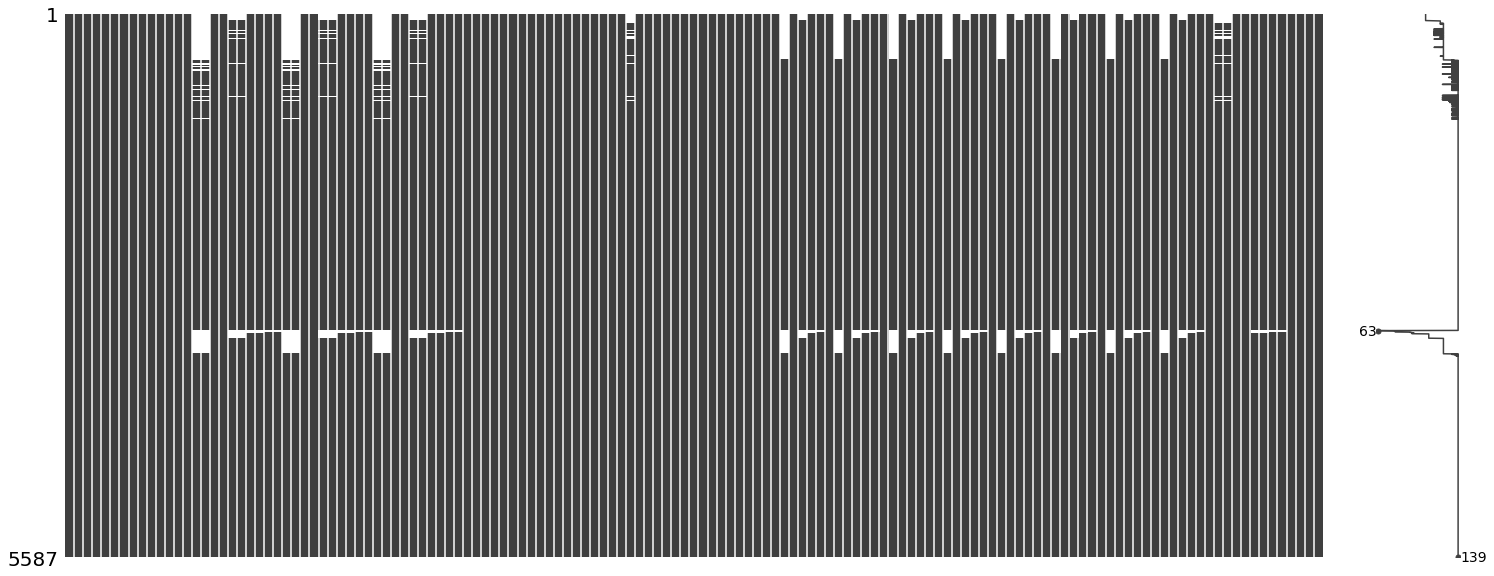

In [ ]:
msno.matrix(train_data[train_data['date'] == 0])

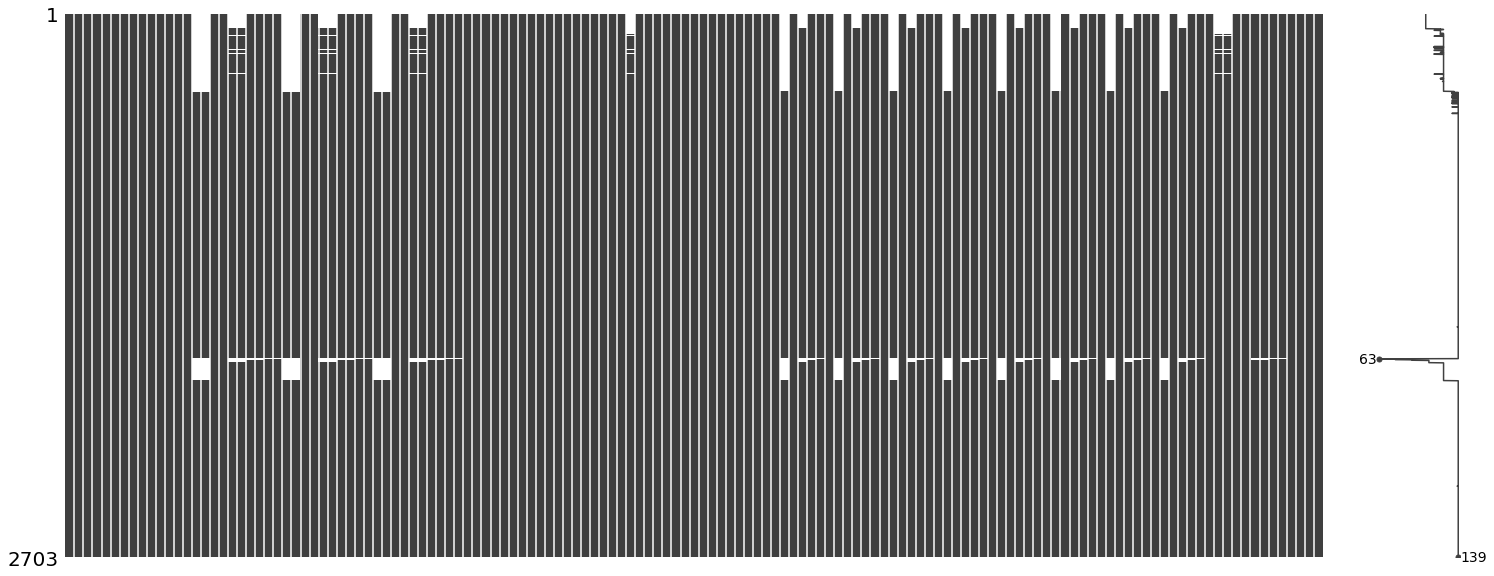

In [ ]:
msno.matrix(train_data[train_data['date'] == 96])

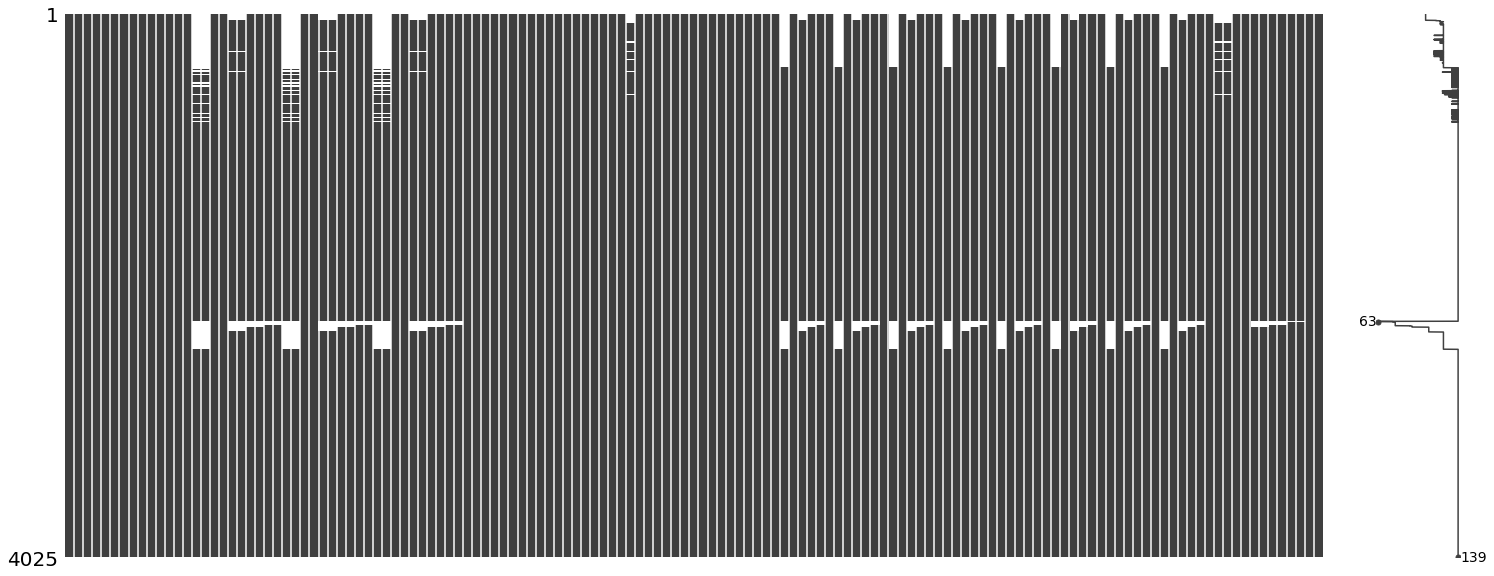

In [ ]:
msno.matrix(train_data[train_data['date'] == 242])

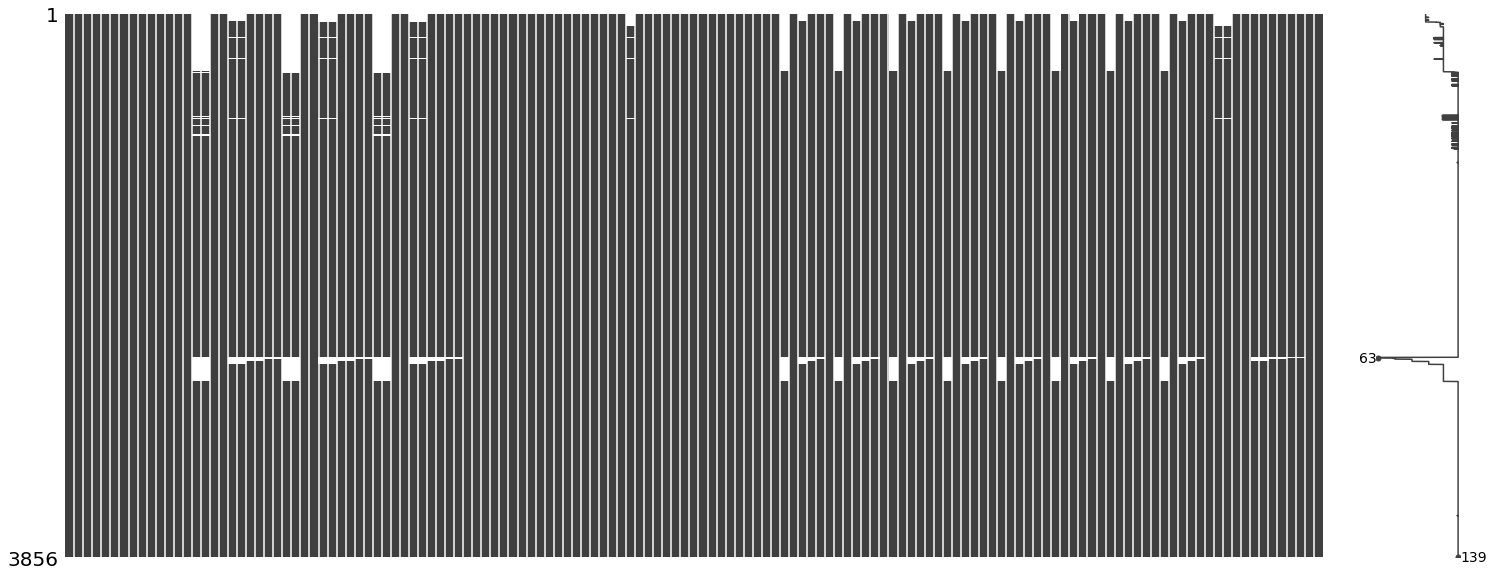

In [ ]:
msno.matrix(train_data[train_data['date'] == 450])

However in the same description ,[comment](https://www.kaggle.com/c/jane-street-market-prediction/discussion/201264#1102401) states that missing data not a function of time but related to stock. 

In [ ]:
for col in tqdm(feature_columns):
    train_data[col] = train_data[col].fillna(train_data[col].median())

100%|██████████| 130/130 [00:05<00:00, 22.20it/s]


### Dimentionality Reduction
With 129 features, we can find out how many features makes enough contribution to the result,
But since we have massive amount of data we will try with SVD if we can reduce the dimention of data.

#### SVD

In [ ]:
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
svd_data = svd.fit_transform(train_data)

In [ ]:
svdOutput = pd.DataFrame(svd_data)
svdOutput.head()

,0,1,2,3,4
0,0.000005,5.373885,1.327365,2.422280,-1.399988
1,1.000029,-1.634842,-2.098377,-3.750962,-10.422257
2,2.000014,3.015134,-0.485070,-3.900750,10.149018
3,3.000005,2.085056,0.381373,-9.265300,9.765894
4,3.999994,-0.876265,1.318436,2.448400,-1.604343


In [ ]:
print(f"The variance explained by each feature after truncated svd is: \n {svd.explained_variance_ratio_}")

The variance explained by each feature after truncated svd is: 
 [9.99999998e-01 5.21592433e-10 2.15718950e-10 1.97928374e-10
 1.58649853e-10]


In [ ]:
svdOutput = pd.concat([svdOutput,train_data['action']],axis=1)
svdOutput.head()

,0,1,2,3,4,action
0,0.000005,5.373885,1.327365,2.422280,-1.399988,1
1,1.000029,-1.634842,-2.098377,-3.750962,-10.422257,0
2,2.000014,3.015134,-0.485070,-3.900750,10.149018,1
3,3.000005,2.085056,0.381373,-9.265300,9.765894,0
4,3.999994,-0.876265,1.318436,2.448400,-1.604343,0


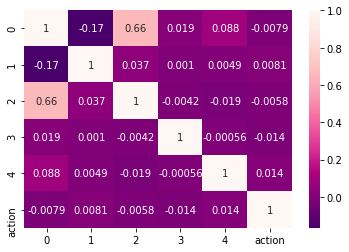

In [ ]:
sns.heatmap(svdOutput.corr(),cmap='RdPu_r',annot=True)

From the plot it gives a great understanding that these features are very less correlated, but they are even less correlated with the target, which is not a good sign.

Other Option to try is to look for autoencoder technique for dimension reduction.

#### Autoencoder

In [ ]:
code_dim = 5
n_inputs = train_data[feature_columns].shape[1]

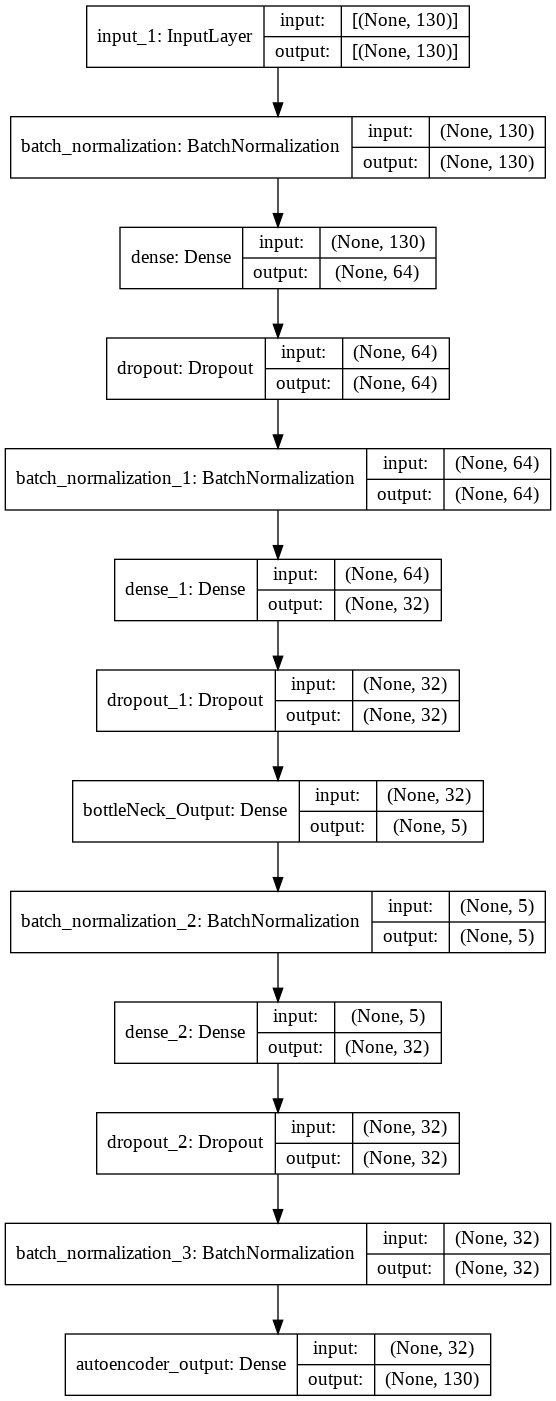

In [ ]:
tf.keras.backend.clear_session()
# define encoder
Input_layer = Input(shape=(n_inputs,))
# encoder level 1
Encoder = BatchNormalization()(Input_layer)
Encoder = Dense(64,activation='relu')(Encoder)
Encoder = Dropout(0.2)(Encoder)
# encoder level 2
Encoder = BatchNormalization()(Encoder)
Encoder = Dense(32,activation='relu')(Encoder)
Encoder = Dropout(0.2)(Encoder)
Bottle_neck = Dense(code_dim,name='bottleNeck_Output')(Encoder)
# decoder level 1
Decoder = BatchNormalization()(Bottle_neck)
Decoder = Dense(32,activation='relu')(Decoder)
Decoder = Dropout(0.2)(Decoder)
# decoder level 2
Decoder = BatchNormalization()(Decoder)
Decoder_output = Dense(n_inputs,activation='sigmoid',name='autoencoder_output')(Decoder)

encoder_model = Model(Input_layer,Bottle_neck)
autoencoder_model = Model(Input_layer,Decoder_output)
autoencoder_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                          loss='binary_crossentropy',metrics=['accuracy'])
plot_model(autoencoder_model, 'autoencoder_compress.png', show_shapes=True)

In [ ]:
autoencoder_model.fit(train_data[feature_columns],train_data[feature_columns],batch_size=256,epochs=10)

Epoch 1/10
9338/9338 [==============================] - 50s 5ms/step - loss: -212.8032 - accuracy: 0.0514
Epoch 2/10
9338/9338 [==============================] - 46s 5ms/step - loss: -2340.5984 - accuracy: 0.0637
Epoch 3/10
9338/9338 [==============================] - 46s 5ms/step - loss: -6541.6265 - accuracy: 0.0647
Epoch 4/10
9338/9338 [==============================] - 46s 5ms/step - loss: -12708.3312 - accuracy: 0.0651
Epoch 5/10
9338/9338 [==============================] - 46s 5ms/step - loss: -20897.1694 - accuracy: 0.0653
Epoch 6/10
9338/9338 [==============================] - 46s 5ms/step - loss: -30969.3803 - accuracy: 0.0654
Epoch 7/10
9338/9338 [==============================] - 46s 5ms/step - loss: -42971.0783 - accuracy: 0.0654
Epoch 8/10
9338/9338 [==============================] - 46s 5ms/step - loss: -57118.6062 - accuracy: 0.0655
Epoch 9/10
9338/9338 [==============================] - 46s 5ms/step - loss: -72891.0235 - accuracy: 0.0656
Epoch 10/10
9338/9338 [=========

In [ ]:
autoencoder_data = pd.DataFrame(encoder_model.predict(train_data[feature_columns]))
autoencoder_data.head()

,0,1,2,3,4
0,2.596898,3.729462,-0.475643,6.099055,2.240392
1,3.923478,3.399578,-10.690681,3.899585,22.481960
2,0.444281,-16.429558,-0.696548,-4.090345,5.465253
3,2.092098,-15.301190,-8.202149,-6.115928,19.824694
4,1.806505,1.711674,-1.886547,6.747633,3.215166


In [ ]:
autoencoder_data = pd.concat([autoencoder_data,train_data['action']],axis=1)
autoencoder_data.head()

,0,1,2,3,4,action
0,2.596898,3.729462,-0.475643,6.099055,2.240392,1
1,3.923478,3.399578,-10.690681,3.899585,22.481960,0
2,0.444281,-16.429558,-0.696548,-4.090345,5.465253,1
3,2.092098,-15.301190,-8.202149,-6.115928,19.824694,0
4,1.806505,1.711674,-1.886547,6.747633,3.215166,0


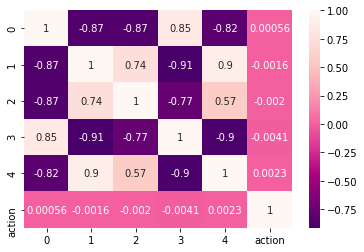

In [ ]:
sns.heatmap(autoencoder_data.corr(),cmap='RdPu_r',annot=True)

#### XGBOOST

In [ ]:
final_features = pd.DataFrame()
final_featurelist = []
final_featureimportance = []

In [ ]:
xgboostclf = XGBClassifier(n_jobs=-1)
xgboostclf.fit(train_data[feature_columns],train_data['action'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

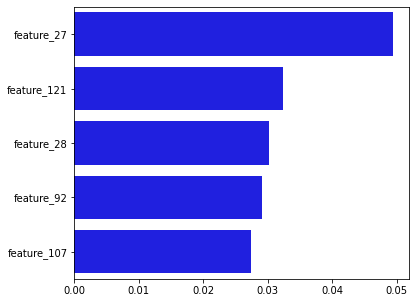

In [ ]:
top_features = np.argsort(xgboostclf.feature_importances_)[::-1][:5]
feature_names = [f'feature_{i}' for i in top_features]
plt.figure(figsize=(6,5))
sns.barplot(xgboostclf.feature_importances_[top_features],feature_names,color='blue')

In [ ]:
XGBoostFeatures = feature_names
XGBoostFeatures

['feature_27', 'feature_121', 'feature_28', 'feature_92', 'feature_107']

In [ ]:
train_data[XGBoostFeatures]

,feature_27,feature_121,feature_28,feature_92,feature_107
0,NaN,NaN,NaN,NaN,-2.238831
1,NaN,NaN,NaN,NaN,-2.209020
2,NaN,NaN,NaN,NaN,-3.568648
3,NaN,NaN,NaN,NaN,-3.373969
4,NaN,NaN,NaN,NaN,-1.742540
...,...,...,...,...,...
2390486,-0.041265,-1.896874,-0.149770,0.532012,3.085763
2390487,-1.301215,-0.936553,-3.244589,2.115330,0.632808
2390488,-0.013002,-2.956745,-0.004482,-0.344158,-0.225225
2390489,0.026421,-2.035894,0.049269,5.206951,15.483735


In [ ]:
xgbOutput = pd.concat([train_data[XGBoostFeatures],train_data['action']],axis=1)
xgbOutput.head()

,feature_27,feature_121,feature_28,feature_92,feature_107,action
0,NaN,NaN,NaN,NaN,-2.238831,1
1,NaN,NaN,NaN,NaN,-2.209020,0
2,NaN,NaN,NaN,NaN,-3.568648,1
3,NaN,NaN,NaN,NaN,-3.373969,0
4,NaN,NaN,NaN,NaN,-1.742540,0


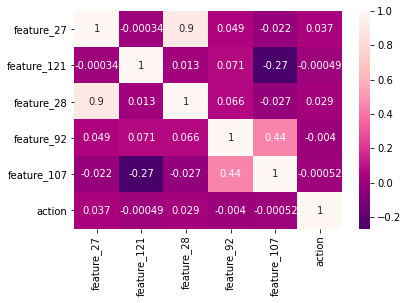

In [ ]:
sns.heatmap(xgbOutput.corr(),cmap='RdPu_r',annot=True)

## Feature CSV Exploration

In [ ]:
feature_data = pd.read_csv('features.csv',index_col=0)
feature_data.head()

,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28
feature,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
feature_0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
feature_1,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
feature_2,False,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
feature_3,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
feature_4,False,False,False,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


features csv contain metadata pertaining to the anonymized features, as explained in the details.

Let us observe Number of Tags involved in each feature.

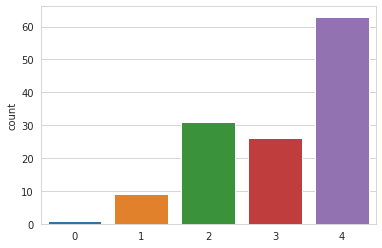

In [ ]:
sns.countplot((feature_data*1).T.sum(axis=0))

Highest number of tags a feature is linked to is 4.

Figuring out, the information that can be explained by these features.csv file.